## Problem Statement: Solar Panel Failure Prediction Model

### Objective(s):
Minimize Human labour/Cost of maintenance


### Constraints: 
 Maximize Output power

### Success Criteria

-  Business Success Criteria: Reduce cost of fault detection by atleast 30%
-  ML Success Criteria :Achieve accuracy greater than 90%
-  Economic Success Criteria:Increase solar scalability and make a profit of atleast 20%

### Data Collection

GPVS-Faults: Experimental Data for fault scenarios in grid-connected PV
systems under MPPT and IPPT modes. {Mendeley Data}
#### Features:
- Time: Time of real measurement in seconds. The average sampling is 𝑇! = 9.9989 𝜇𝑠.
- Ipv: PV array current measurement.
- Vpv: PV array voltage measurement.
- Vdc: DC voltage measurement.
- ia: Phase_A current measurement.
- ib: Phase_B current measurement.
- ic: Phase_C current measurement.
- va: Phase_A voltage measurement.
- vb: Phase_B voltage measurement.
- vc: Phase_C voltage measurement.
- Iabc: Positive-sequence estimated current magnitude.
- If: Positive-sequence estimated current frequency.
- Vabc: Positive-sequence estimated voltage magnitude.
- Vf: Positive-sequence estimated vurrent frequency.

### DATA PREPARATION

In [40]:
### Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, probplot
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer

%matplotlib inline

In [2]:
# Make two dataframes one with faults and with no faults
# output column denoting F for fault and NF for no fault respectively
column_names= ['Time','Ipv','Vpv','Vdc','ia','ib','ic','va','vb','vc','Iabc','If','Vabc','Vf','label']
solar_data_with_no_fault=pd.DataFrame(columns=column_names)
solar_data_with_fault=pd.DataFrame(columns=column_names)

for num in range(0,1):
    df = pd.read_csv(r"D:\CSV_Files\F{}L.csv".format(num))
    df1 = pd.read_csv(r"D:\CSV_Files\F{}M.csv".format(num))
    df2 = pd.concat([df,df1] , axis=0)
    df2['label']=np.full((len(df2), 1), 'NF'.format(num))
    solar_data_with_no_fault=pd.concat([solar_data_with_no_fault ,df2 ], ignore_index=True)
    
for num in range (1,8):
    df3 = pd.read_csv(r"D:\CSV_Files\F{}L.csv".format(num))
    df4 = pd.read_csv(r"D:\CSV_Files\F{}M.csv".format(num))
    df5 = pd.concat([df3,df4] , axis=0)
    df5['label']=np.full((len(df5), 1), 'F'.format(num))
    solar_data_with_fault=pd.concat([solar_data_with_fault , df5], ignore_index=True)

In [3]:
solar_data_with_no_fault.shape

(284729, 15)

In [4]:
solar_data_with_fault.shape

(1878751, 15)

In [5]:
### Concatenate both the dataframes to make final dataset
final_solar = pd.concat([solar_data_with_fault, solar_data_with_no_fault], axis=0)
final_solar.shape

(2163480, 15)

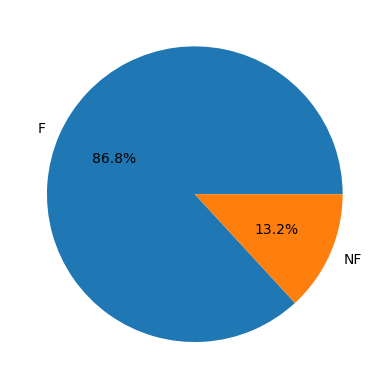

In [6]:
## checking if the dataset is balanced or not
# Select the output feature column
output_feature = final_solar["label"]

# Get the unique values and their counts
unique_values, counts = np.unique(output_feature, return_counts=True)

# Create a dictionary of unique values and their counts
count_dict = dict(zip(unique_values, counts))

# Plot the pie chart
plt.pie(count_dict.values(), labels=count_dict.keys(), autopct='%1.1f%%')
plt.show()

### OBSERVATION 1: The final solar dataset is imbalanced so we do downsampling to make it a balanced dataset and also we drop the time variable as it is not required in modelling of our business problem of fault detection

In [7]:
### Balancing the dataset
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = final_solar[final_solar['label']=="F"]
df_minority = final_solar[final_solar['label']=="NF"]
# calculate the downsampling ratio
ratio = (len(df_minority) * 1.5) / len(df_majority)

# downsample majority class
df_majority_downsampled = df_majority.sample(frac=ratio)

# combine minority and downsampled majority
final_solar_balanced = pd.concat([df_majority_downsampled, df_minority])
# Removing the time variable from the dataset
final_solar_balanced.drop('Time', axis=1, inplace=True)
# Display the new class count
print(final_solar_balanced['label'].value_counts())


F     427094
NF    284729
Name: label, dtype: int64


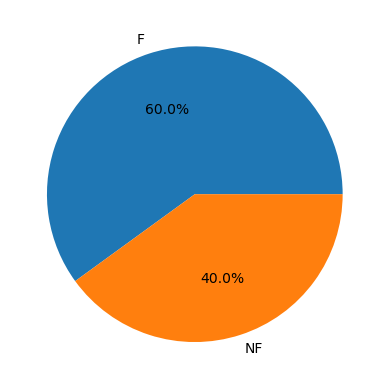

In [8]:
## checking if the balanced dataset 
# Select the output feature column
output_feature = final_solar_balanced["label"]

# Get the unique values and their counts
unique_values, counts = np.unique(output_feature, return_counts=True)

# Create a dictionary of unique values and their counts
count_dict = dict(zip(unique_values, counts))

# Plot the pie chart
plt.pie(count_dict.values(), labels=count_dict.keys(), autopct='%1.1f%%')
plt.show()

### SQL : push this balanced dataset into sql and later retrieve it and perform EDA

##### Create a new database
import pymysql
##### Connect to the database
conn = pymysql.connect(host='localhost',
                       user='root',
                       password='Muzahid@98')
##### Create a cursor object
cursor = conn.cursor()
##### Define the name of the new database
db_name = 'solar_panel_database'
##### Create the new database
cursor.execute(f'CREATE DATABASE {db_name}')
##### Close the connection
conn.close()

In [9]:
### push the dataframe into sql
import pandas as pd
from sqlalchemy import create_engine
# Connect to the database
engine = create_engine('sqlite:///solar_panel_database.db')
# Insert the DataFrame into the database
final_solar_balanced.to_sql(name='solar_dataset', con=engine, if_exists='replace', index=False)

711823

In [10]:
### fetch the table to verify
import sqlite3
# Connect to the database
conn = sqlite3.connect("solar_panel_database.db")
cursor = conn.cursor()
# Execute the 'SHOW TABLES' command
cursor.execute("SELECT name from sqlite_master WHERE type='table';")
# Fetch all the results
tables = cursor.fetchall()
# Print the results
for table in tables:
    print(table)
# Close the connection
conn.close()

('solar_dataset',)


### EXPLORATORY DATA ANALYSIS

In [11]:
### Retrieve the table from sql
# Connect to the database
conn = sqlite3.connect("solar_panel_database.db")
cursor = conn.cursor()
# Define the name of the table to retrieve
table = 'solar_dataset'
# Retrieve the data from the table
cursor.execute(f"SELECT * FROM {table}")
data = cursor.fetchall()
# Create a DataFrame from the retrieved data
solar_data_final = pd.DataFrame(data)
# Close the connection
conn.close()
#print the dataframe
solar_data_final.columns=['Ipv','Vpv','Vdc','ia','ib','ic','va','vb','vc','Iabc','If','Vabc','Vf','label']
solar_data_final
#solar_data_final.to_csv('solar_data_final.csv', index=False)

Ipv         Vpv         Vdc        ia        ib        ic  \
0       1.537323  101.550293  144.140625 -0.302979  0.490112 -0.140142   
1       2.386871   85.388184  147.656250 -0.665528  0.362549  0.309688   
2       1.924255   87.658691  144.140625 -0.014283 -0.429688  0.470820   
3       2.418091   86.920166  147.949219  0.281127  0.422974 -0.663823   
4       2.541077   88.006592  145.605469  0.220702 -0.584106  0.470820   
...          ...         ...         ...       ...       ...       ...   
711818  2.234558   90.533447  147.363281  0.603393 -0.617676 -0.059575   
711819  2.206177   90.606689  147.363281  0.610106 -0.624390 -0.086431   
711820  2.217529   90.637207  146.484375  0.616820 -0.604248 -0.113286   
711821  2.205231   90.765381  147.363281  0.630248 -0.604248 -0.133428   
711822  2.264832   90.637207  147.363281  0.636962 -0.577393 -0.140142   

                va          vb          vc      Iabc         If        Vabc  \
0       114.312286 -147.160645   33.238118  0.479084  49.821986  154.896746   
1       154.779053  -79.788361  -75.139364  0.670398  50.123119  155.013461   
2        -2.881012  135.648651 -133.406525  0.502826  50.002238  155.450527   
3       -72.495422  -80.451355  157.627920  0.738432  49.946376  156.133636   
4       -42.238770  149.426880 -109.619090  0.665266  50.030233  154.814391   
...            ...         ...         ...       ...        ...         ...   
711818 -132.972565  136.950531    2.760468  0.734241  49.783734  155.610385   
711819 -135.781250  134.419098    7.662608  0.734241  49.783734  155.610385   
711820 -137.697906  131.610413   12.416077  0.734184  49.779304  155.613726   
711821 -140.072632  129.766083   17.213745  0.734184  49.779304  155.613726   
711822 -141.422729  125.679626   22.139994  0.734184  49.779304  155.613726   

               Vf label  
0       49.998099     F  
1       50.003817     F  
2       49.993699     F  
3       50.005160     F  
4       49.994412     F  
...           ...   ...  
711818  49.992107    NF  
711819  49.992107    NF  
711820  49.992726    NF  
711821  49.992726    NF  
711822  49.992726    NF  

[711823 rows x 14 columns]

In [12]:
# basic statistics about the dataset
solar_data_final.describe().T

count        mean         std           min         25%         50%  \
Ipv   711823.0    1.810339    0.550599 -5.846558e-01    1.476776    1.788025   
Vpv   711823.0   90.483172   19.935170 -1.622925e+01   87.951660   91.577148   
Vdc   711823.0  141.139935   22.968543  5.859375e-01  142.968750  144.433594   
ia    711823.0   -0.018215    0.533719 -6.358888e+00   -0.390260   -0.014283   
ib    711823.0    0.000912    0.536142 -7.297974e+00   -0.362549    0.006714   
ic    711823.0   -0.026140    0.523238 -1.272864e+01   -0.368413   -0.032720   
va    711823.0    0.928284  109.794487 -1.622046e+02 -108.863678    1.024628   
vb    711823.0    0.656607  109.822194 -1.622046e+02 -109.056549    0.602722   
vc    711823.0    0.752807  109.872859 -1.600348e+02 -109.189148    0.707194   
Iabc  711823.0    0.573466    0.468964  4.937596e-08    0.465692    0.506327   
If    711823.0   49.758151    3.113107 -2.225850e-02   49.923086   50.006525   
Vabc  711823.0  155.028254    6.107412  1.000000e+00  155.030778  155.291606   
Vf    711823.0   49.999538    0.020504  4.944632e+01   49.996539   50.000094   

             75%         max  
Ipv     2.271454   11.208740  
Vpv   101.306152  110.943604  
Vdc   147.363281  250.781250  
ia      0.361693   13.769286  
ib      0.369263    6.807861  
ic      0.336543    6.358882  
va    110.623627  161.204071  
vb    110.539246  161.204071  
vc    110.555318  159.709320  
Iabc    0.689015    6.762046  
If     50.097240   51.862775  
Vabc  155.537269  156.291664  
Vf     50.003566   50.464243

In [13]:
solar_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711823 entries, 0 to 711822
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Ipv     711823 non-null  float64
 1   Vpv     711823 non-null  float64
 2   Vdc     711823 non-null  float64
 3   ia      711823 non-null  float64
 4   ib      711823 non-null  float64
 5   ic      711823 non-null  float64
 6   va      711823 non-null  float64
 7   vb      711823 non-null  float64
 8   vc      711823 non-null  float64
 9   Iabc    711823 non-null  float64
 10  If      711823 non-null  float64
 11  Vabc    711823 non-null  float64
 12  Vf      711823 non-null  float64
 13  label   711823 non-null  object 
dtypes: float64(13), object(1)
memory usage: 76.0+ MB


### OBSERVATION 2: All are numerical features except label and no missing value

In [14]:
# LIST OF NUMERICAL FEATURES
Numerical_features=[feature for feature in solar_data_final.columns if solar_data_final[feature].dtype!='object']

In [15]:
Numerical_features

['Ipv',
 'Vpv',
 'Vdc',
 'ia',
 'ib',
 'ic',
 'va',
 'vb',
 'vc',
 'Iabc',
 'If',
 'Vabc',
 'Vf']

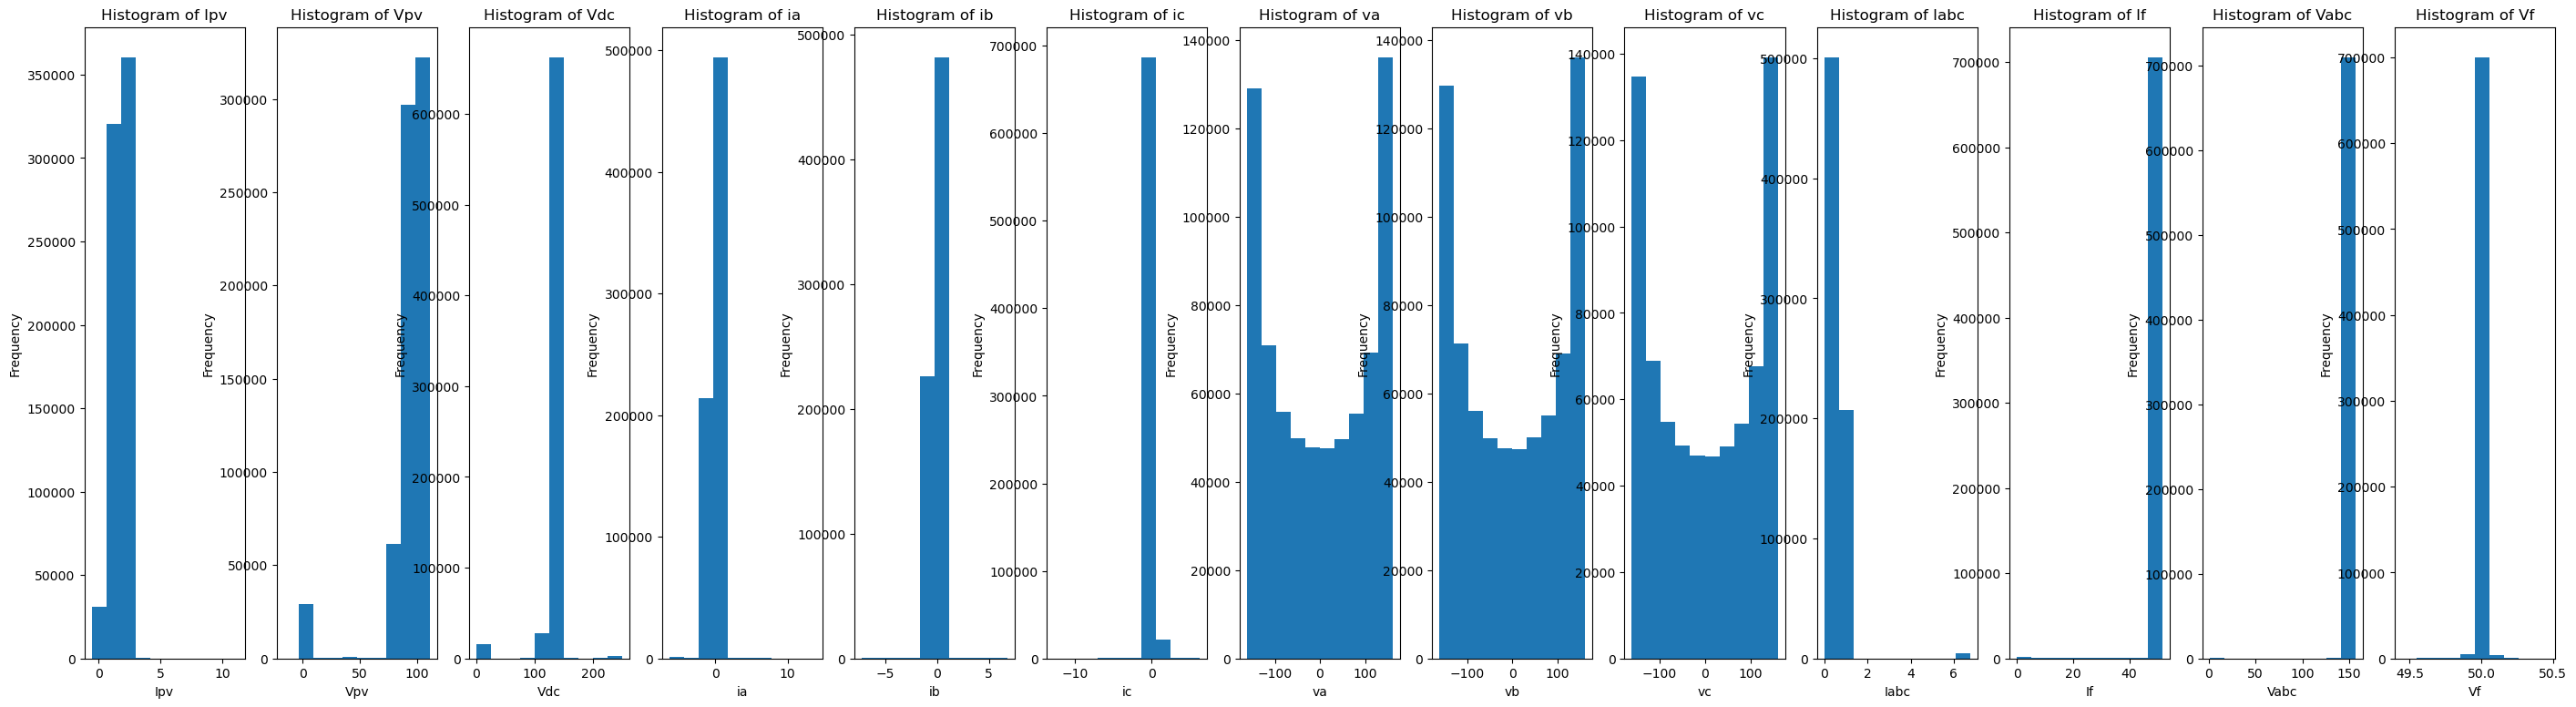

In [16]:
## Visualise the numerical features
fig, axes = plt.subplots(nrows=1, ncols=len(Numerical_features), figsize=(35,9))

for i, col in enumerate(Numerical_features):
    axes[i].hist(solar_data_final[col], bins = 10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title('Histogram of {}'.format(col))

plt.show()

### OBSERVATION 3: Most of the features are skewed and some of them have outliers. 

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


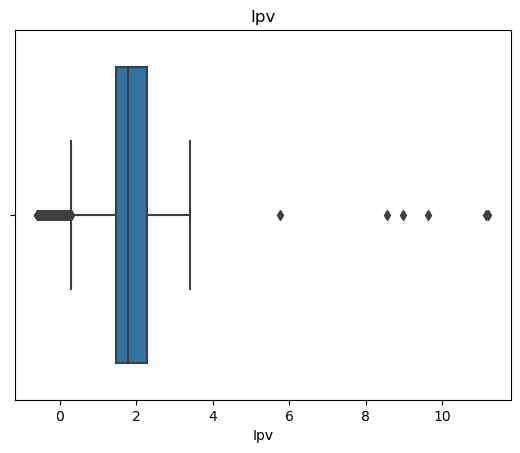

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


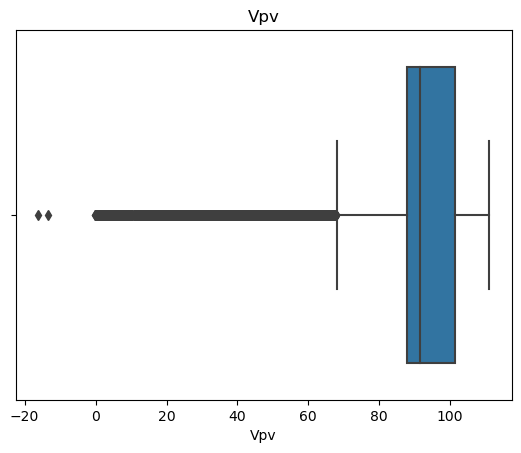

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


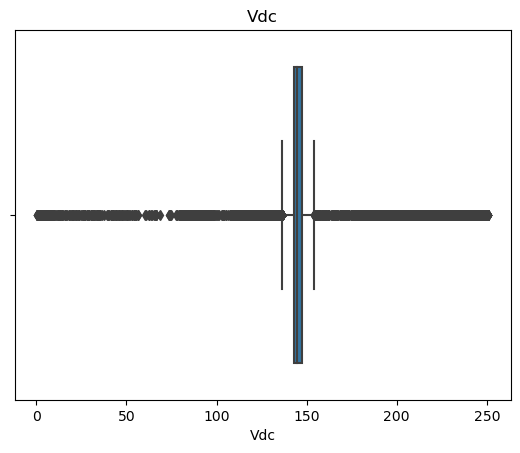

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


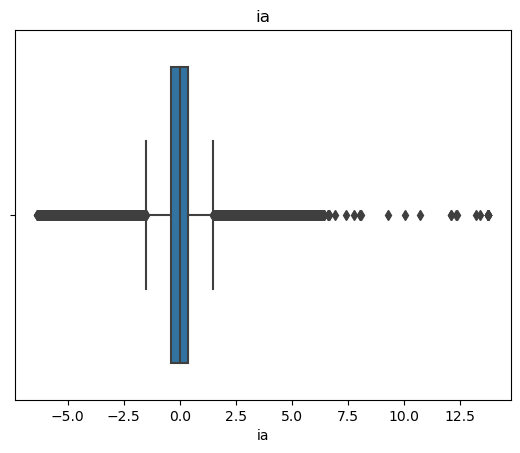

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


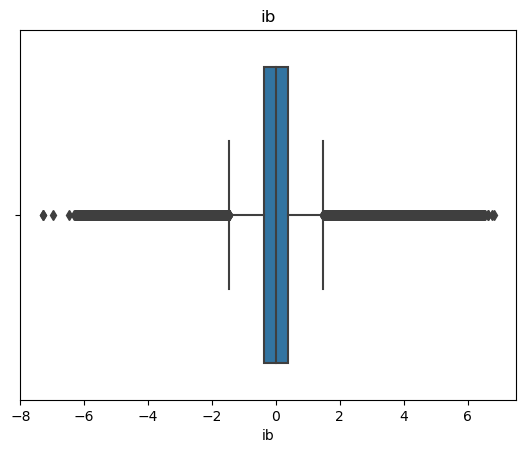

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


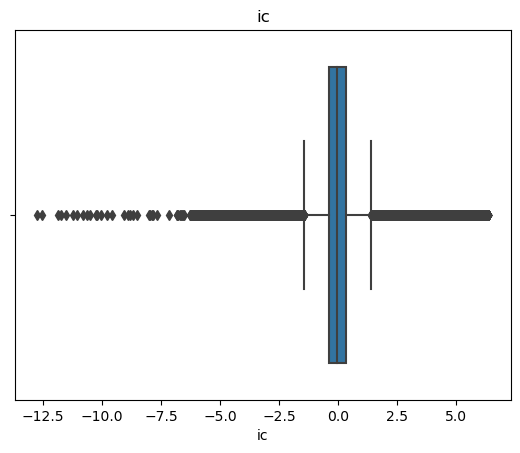

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


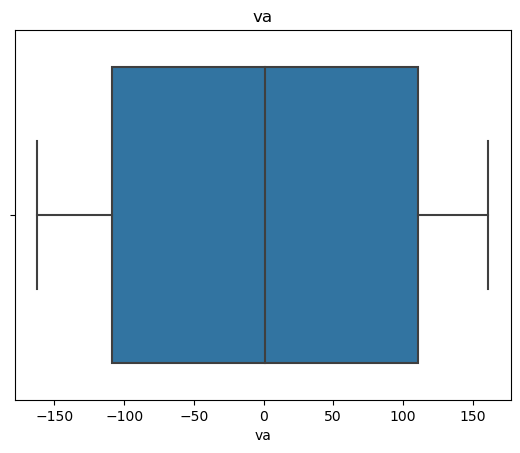

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


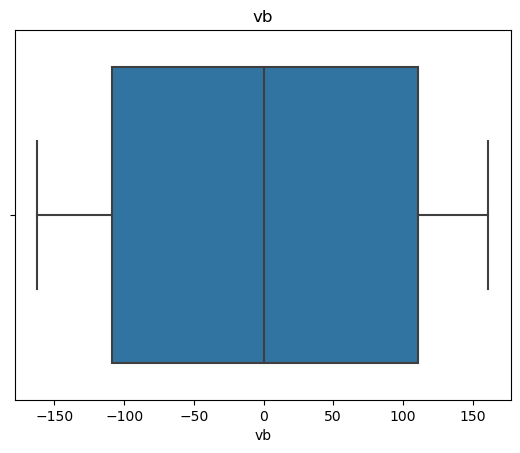

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


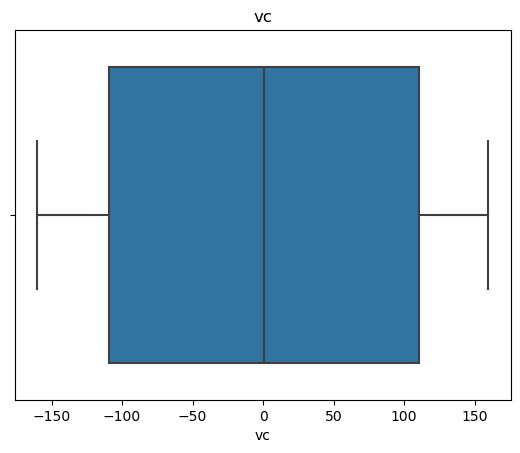

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


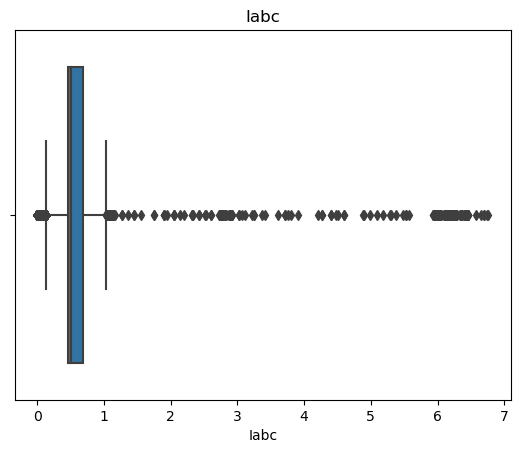

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


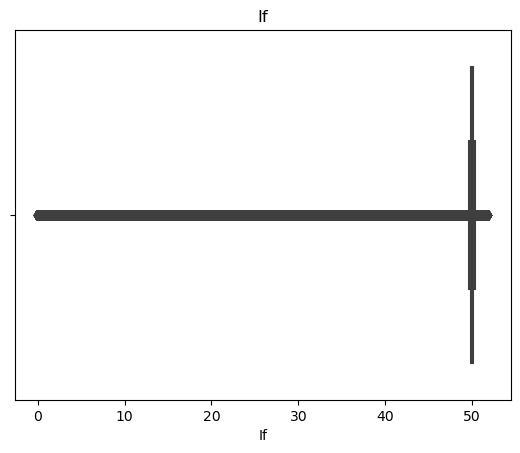

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


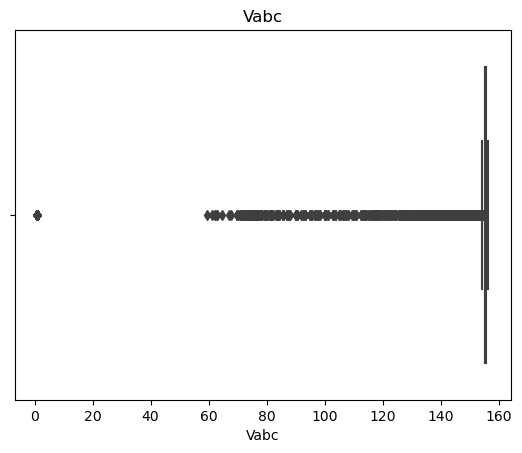

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


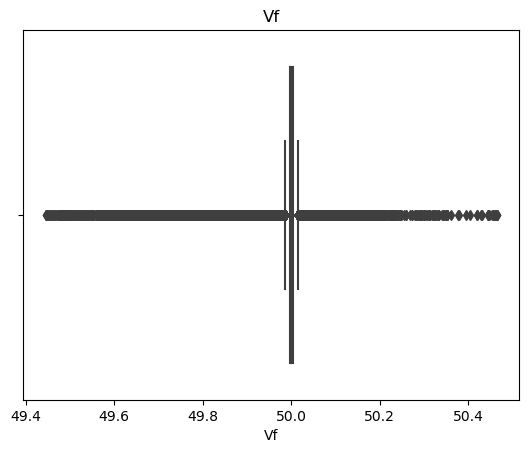

In [17]:
## VERIFYING OUTLIERS
for col in Numerical_features:
    sns.boxplot(solar_data_final[col])
    plt.title(col)
    plt.show()

### OBSERVATION 4: Outliers are present in a number of features which is confirmed by the boxplots

In [18]:
feature_with_outliers=['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'Iabc', 'If', 'Vabc', 'Vf']
feature_with_outliers

['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'Iabc', 'If', 'Vabc', 'Vf']

### Bivariate analysis

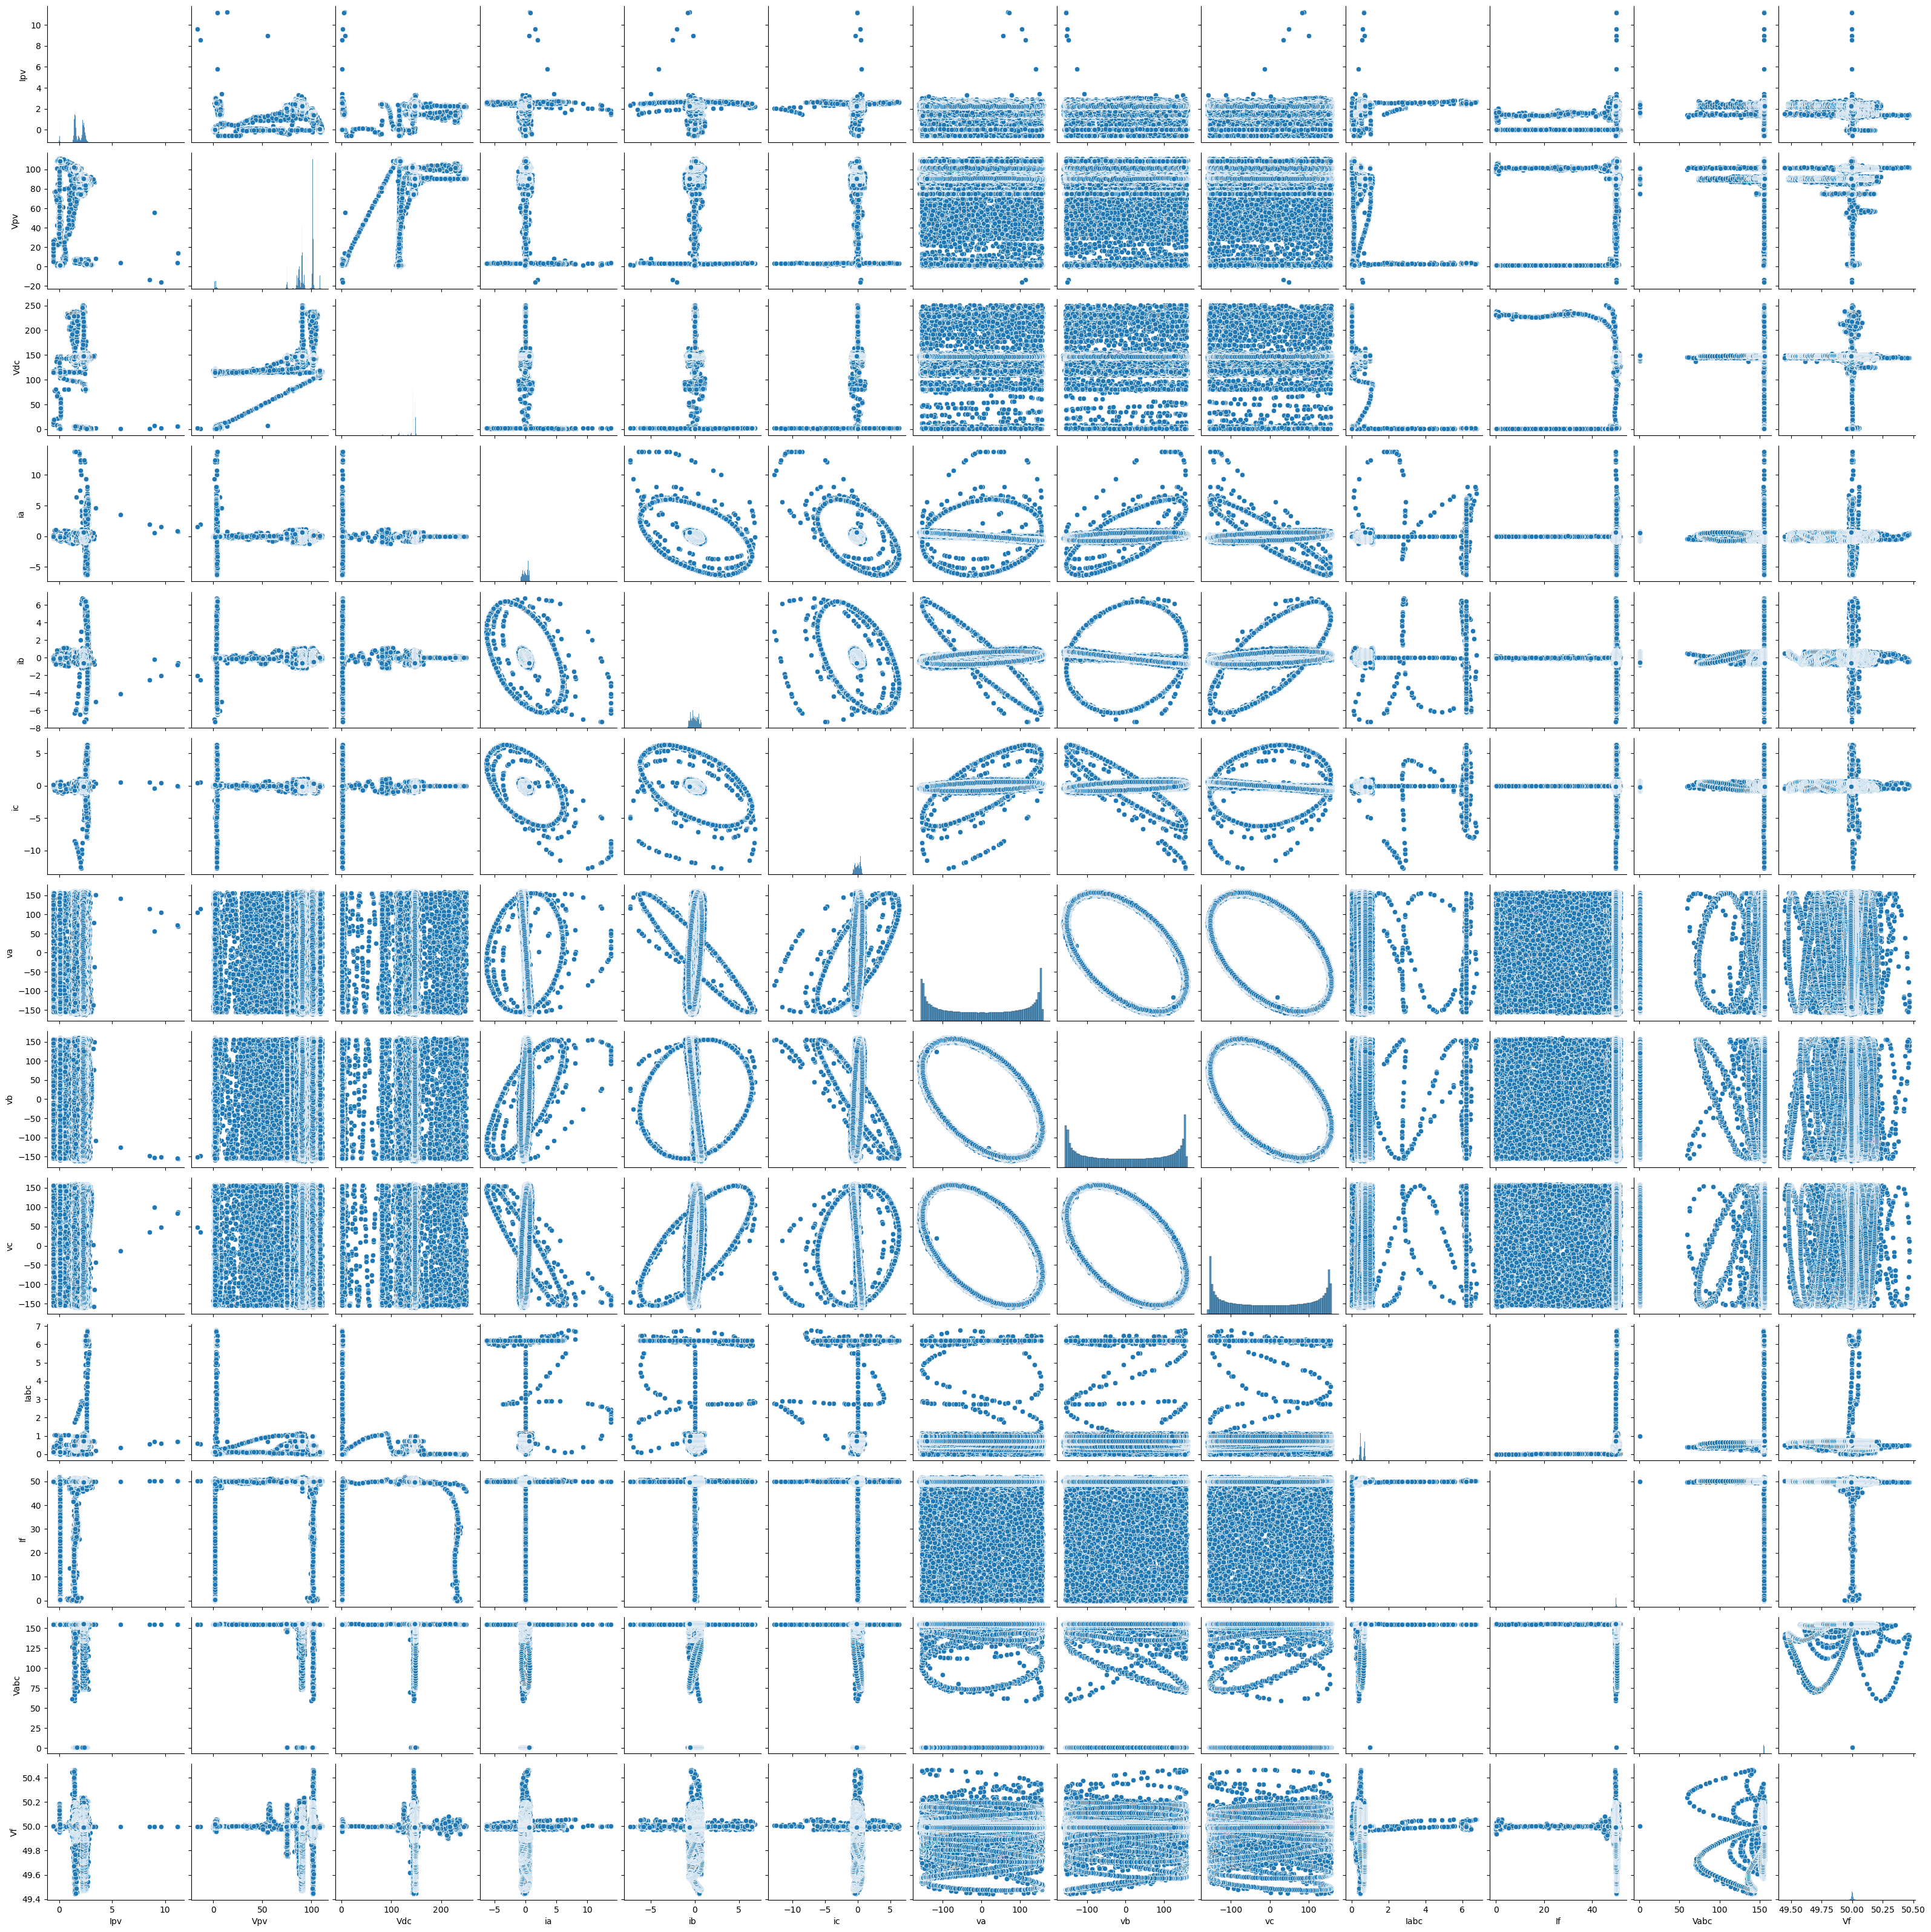

In [19]:
#Pairplot
sns.pairplot(solar_data_final)

In [20]:
# creating a correlation matrix
corr = solar_data_final.corr()
corr

Ipv       Vpv       Vdc        ia        ib        ic        va  \
Ipv   1.000000  0.026953  0.145351  0.002608 -0.013942  0.001609  0.000903   
Vpv   0.026953  1.000000  0.699978  0.000654  0.005410 -0.011565 -0.001156   
Vdc   0.145351  0.699978  1.000000  0.004944  0.000843 -0.007307  0.001170   
ia    0.002608  0.000654  0.004944  1.000000 -0.498115 -0.480554 -0.705629   
ib   -0.013942  0.005410  0.000843 -0.498115  1.000000 -0.490233  0.316037   
ic    0.001609 -0.011565 -0.007307 -0.480554 -0.490233  1.000000  0.374042   
va    0.000903 -0.001156  0.001170 -0.705629  0.316037  0.374042  1.000000   
vb   -0.002972 -0.000804 -0.001180  0.407844 -0.693124  0.299180 -0.507933   
vc    0.000297  0.000338 -0.000615  0.296803  0.383046 -0.678695 -0.491485   
Iabc  0.366701 -0.205086 -0.287956 -0.020115  0.006780  0.025431  0.000333   
If    0.138871  0.172740  0.096514 -0.002778  0.000456 -0.000720 -0.000192   
Vabc -0.006556 -0.009173 -0.007761 -0.000974  0.001602 -0.002828  0.000674   
Vf   -0.020255 -0.001803 -0.007854  0.001053  0.000959 -0.001432 -0.001124   

            vb        vc      Iabc        If      Vabc        Vf  
Ipv  -0.002972  0.000297  0.366701  0.138871 -0.006556 -0.020255  
Vpv  -0.000804  0.000338 -0.205086  0.172740 -0.009173 -0.001803  
Vdc  -0.001180 -0.000615 -0.287956  0.096514 -0.007761 -0.007854  
ia    0.407844  0.296803 -0.020115 -0.002778 -0.000974  0.001053  
ib   -0.693124  0.383046  0.006780  0.000456  0.001602  0.000959  
ic    0.299180 -0.678695  0.025431 -0.000720 -0.002828 -0.001432  
va   -0.507933 -0.491485  0.000333 -0.000192  0.000674 -0.001124  
vb    1.000000 -0.500216 -0.001472  0.000335 -0.002910 -0.000075  
vc   -0.500216  1.000000  0.001430 -0.000443  0.003326  0.001493  
Iabc -0.001472  0.001430  1.000000  0.103663 -0.032331  0.000935  
If    0.000335 -0.000443  0.103663  1.000000 -0.003906 -0.001579  
Vabc -0.002910  0.003326 -0.032331 -0.003906  1.000000  0.063256  
Vf   -0.000075  0.001493  0.000935 -0.001579  0.063256  1.000000

<AxesSubplot:>

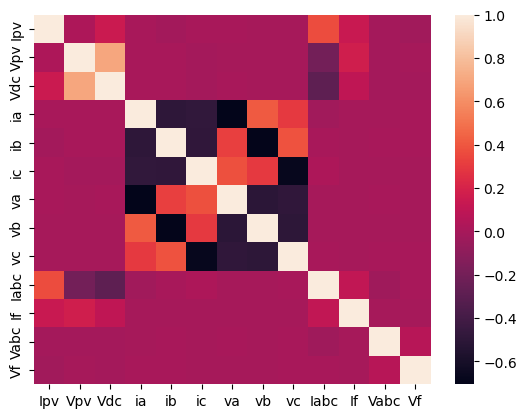

In [21]:
# creating a heatmap of the correlation matrix
sns.heatmap(corr)

### OBSERVATION 5: We can conclude that only a few features have positive correlation. Clusters are seen in few features. No multicollinearity issue

### AUTOMATING THE EDA PROCESS

Using sweetviz to automate EDA is pretty simple and straight forward. 3 simple steps will provide a detailed report in html page.

step 1. Install sweetviz package using pip.
- !pip install sweetviz

step2. import sweetviz package and call analyze function on the dataframe.

step3. Display the report on a html page created in the working directory with show_html function.


In [22]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


                                             |                                             | [  0%]   00:00 ->…


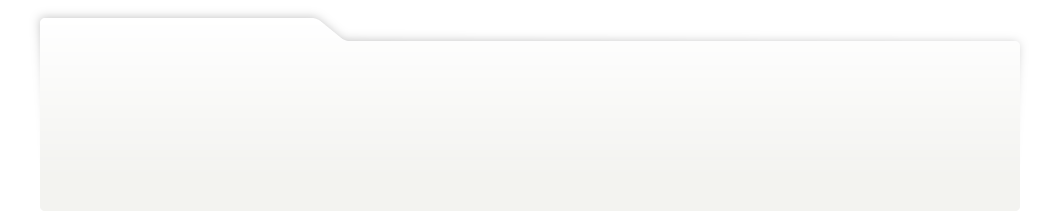
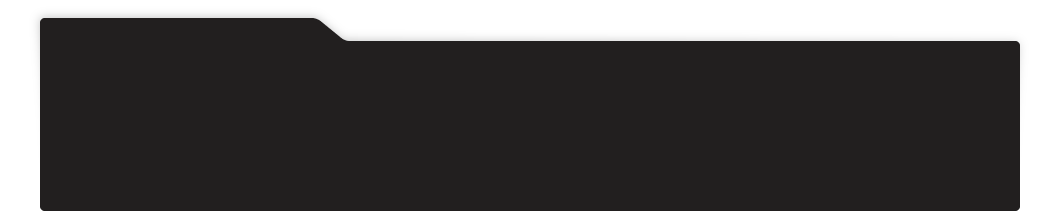
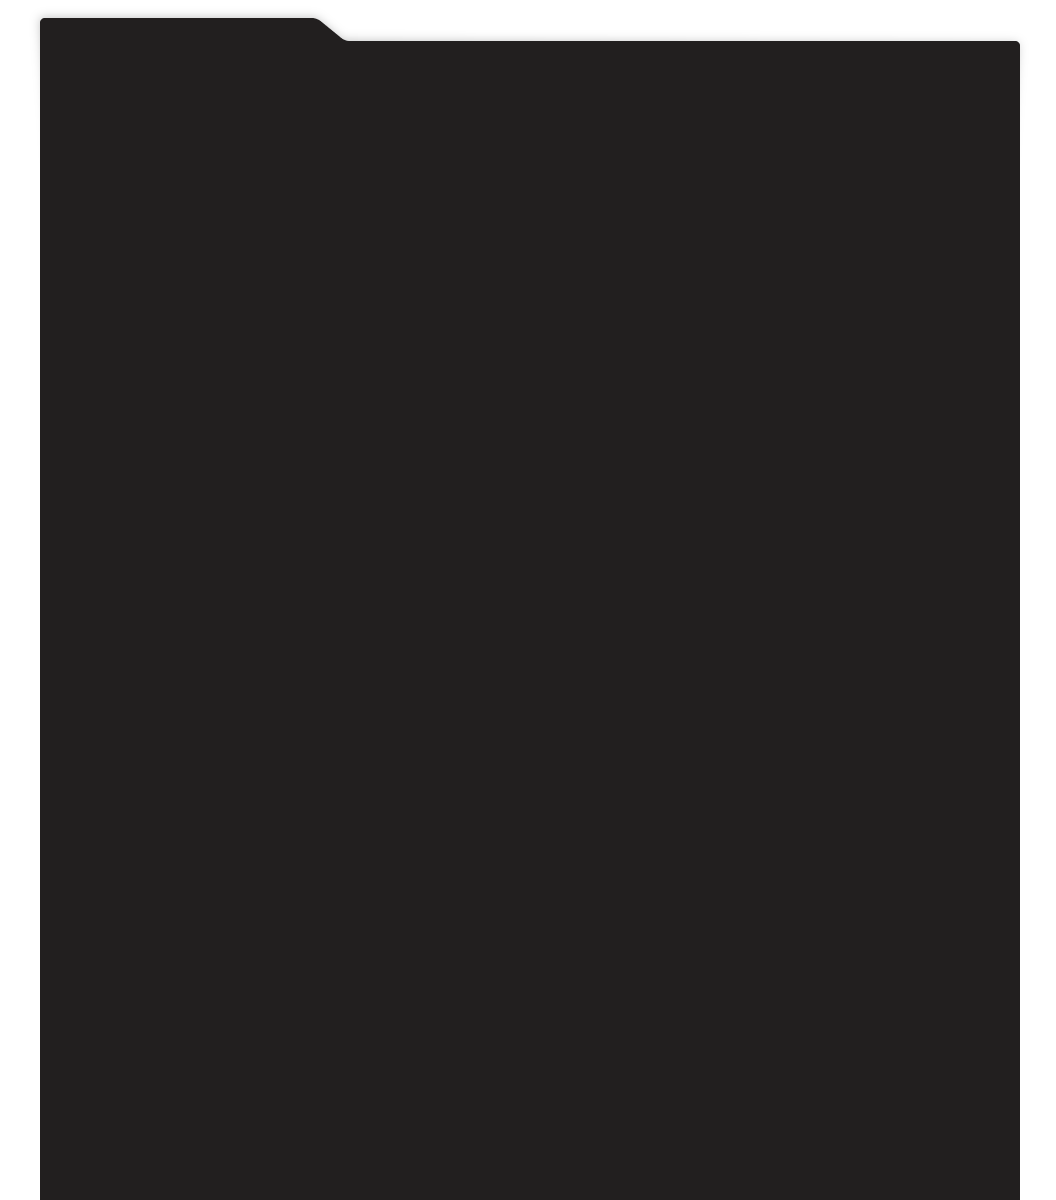
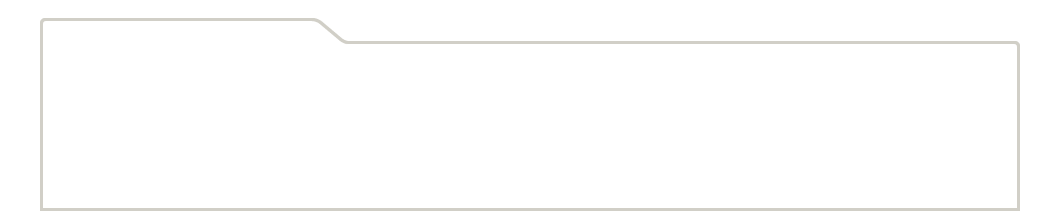
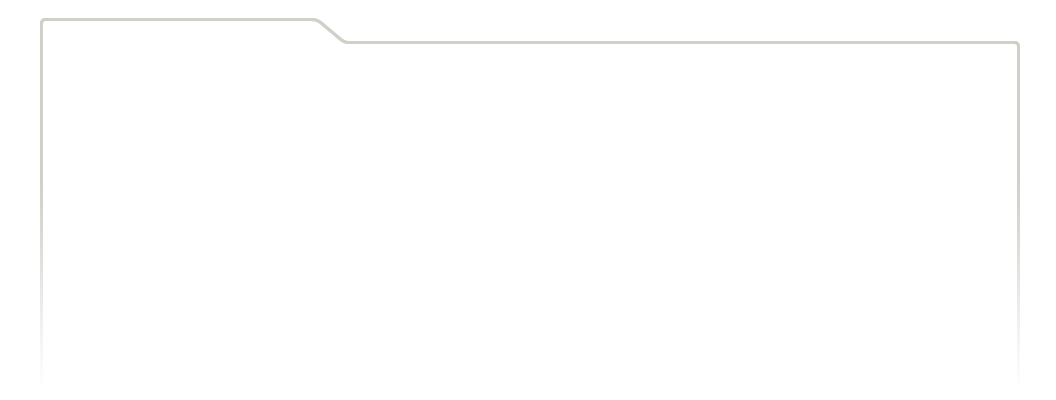
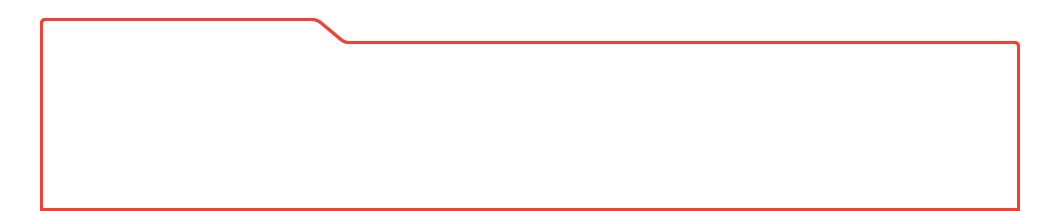
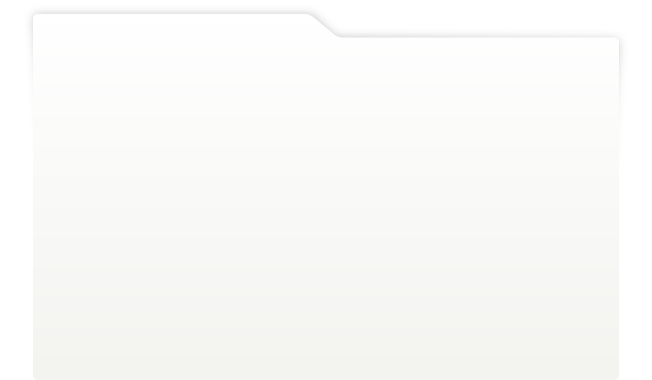
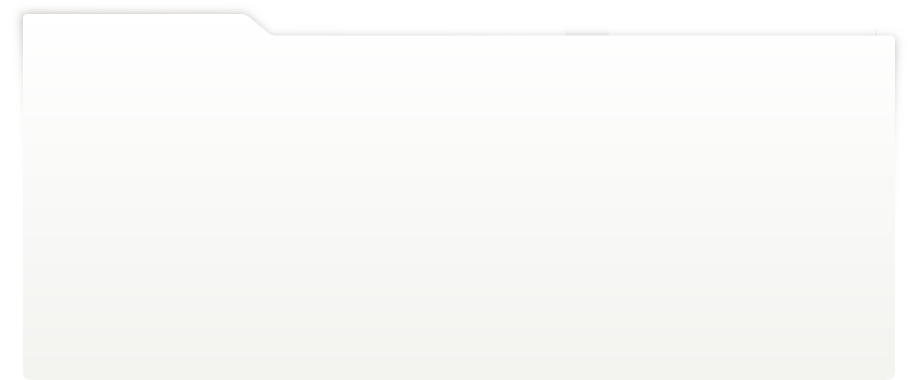
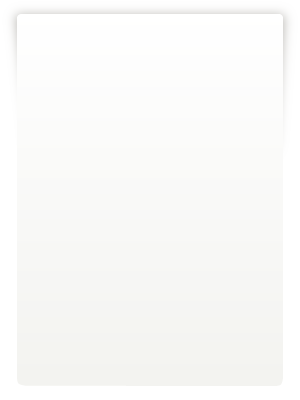
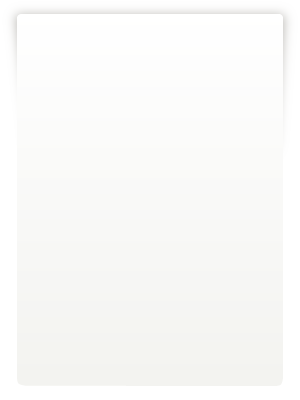
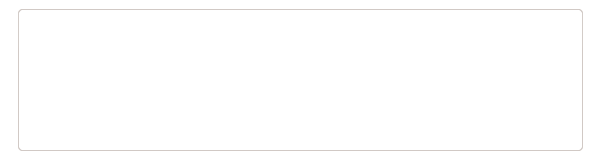
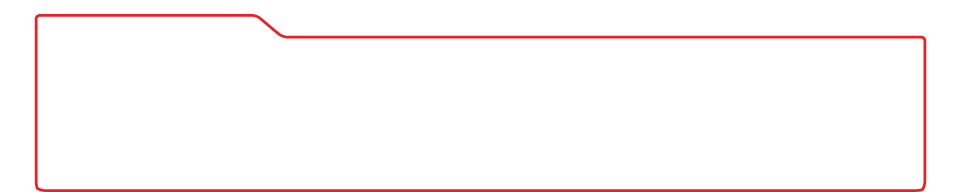
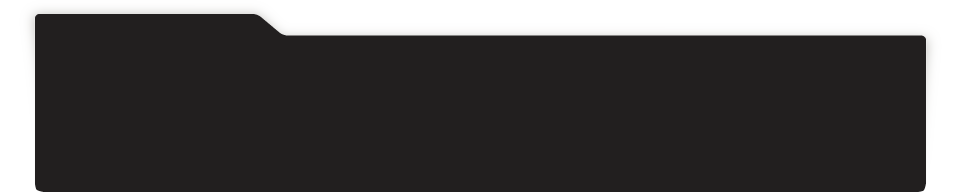
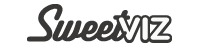
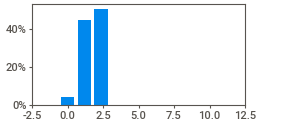
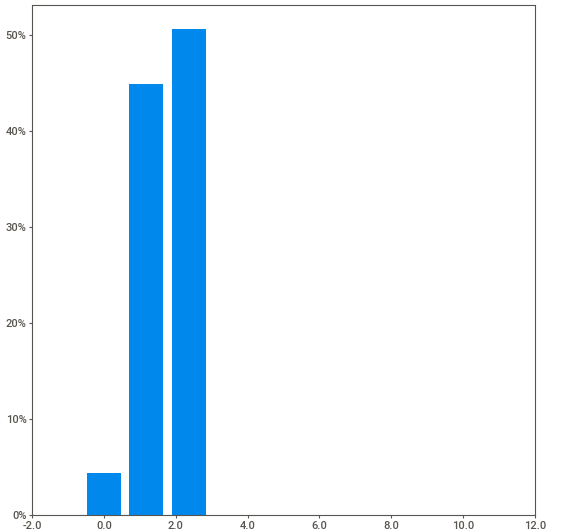
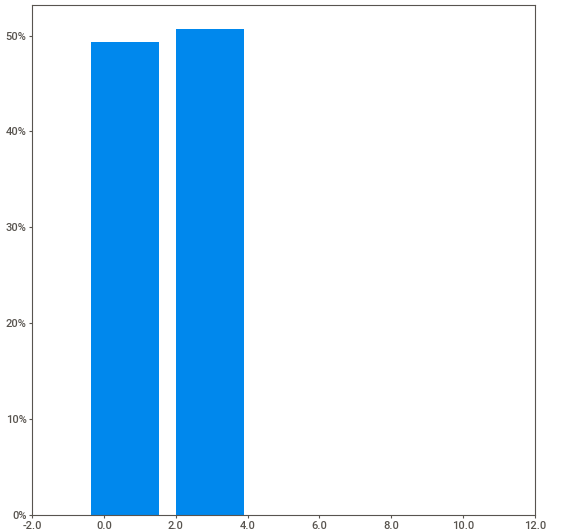
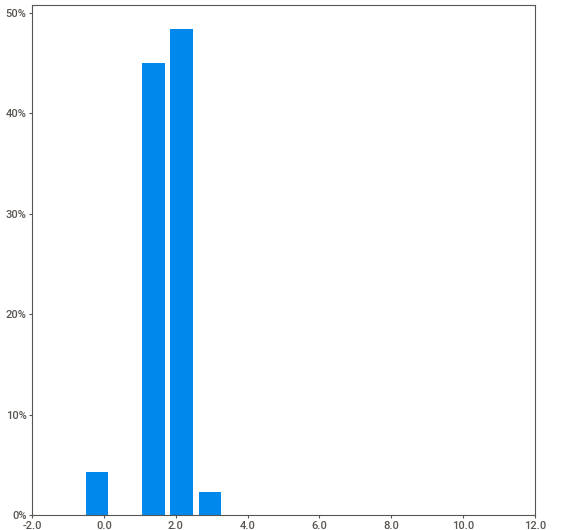
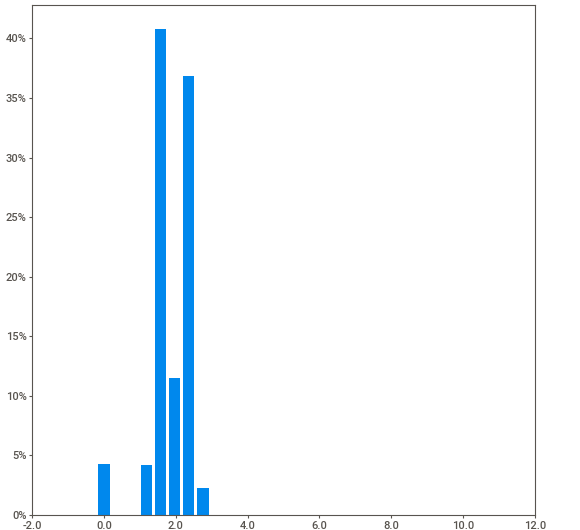
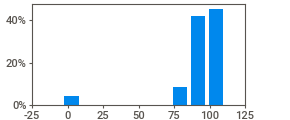
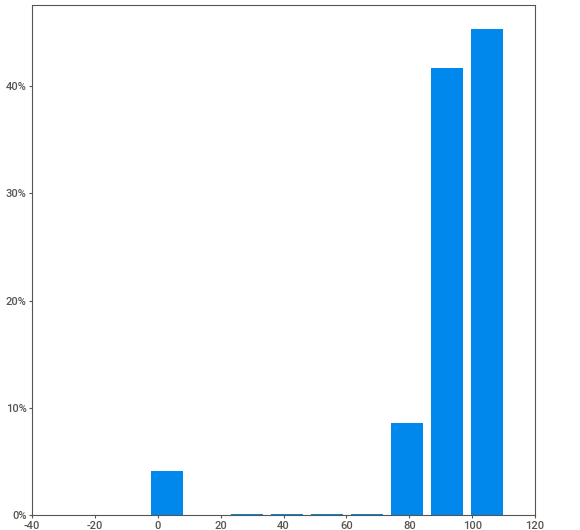
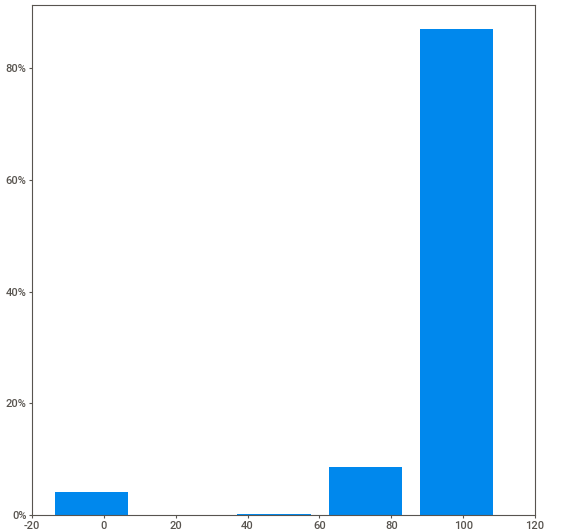
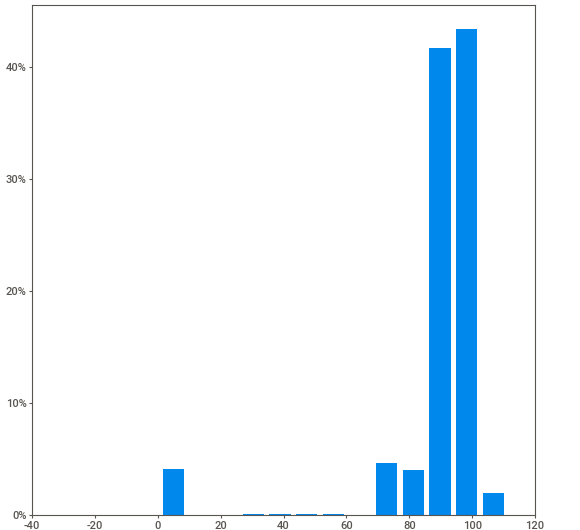
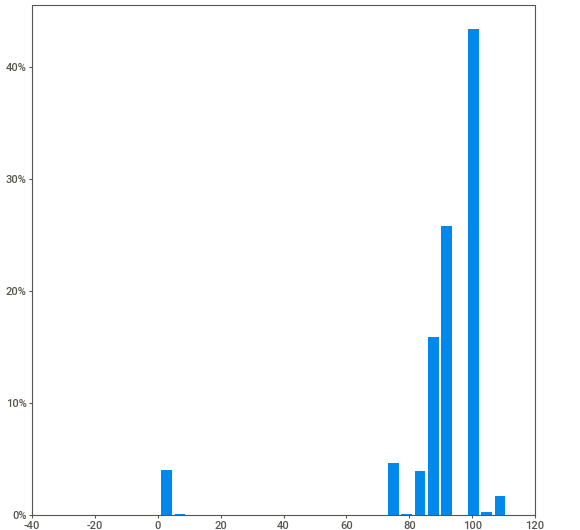
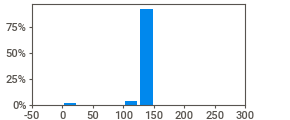
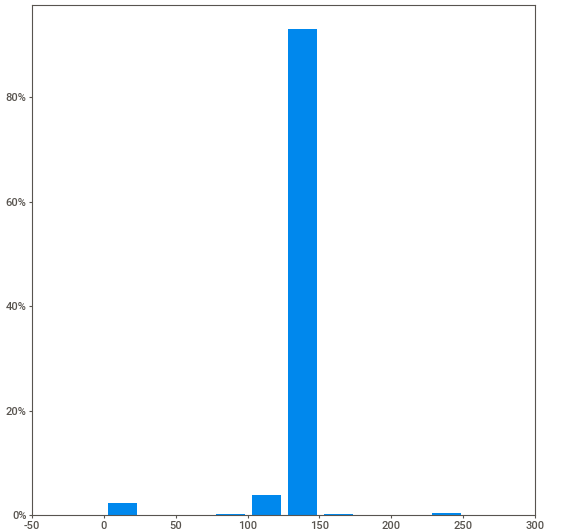
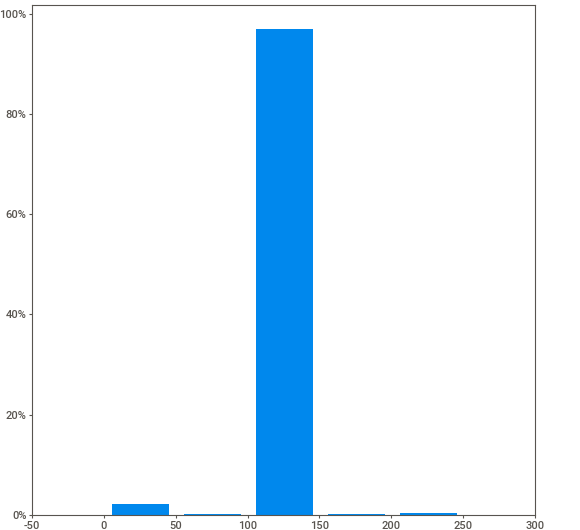
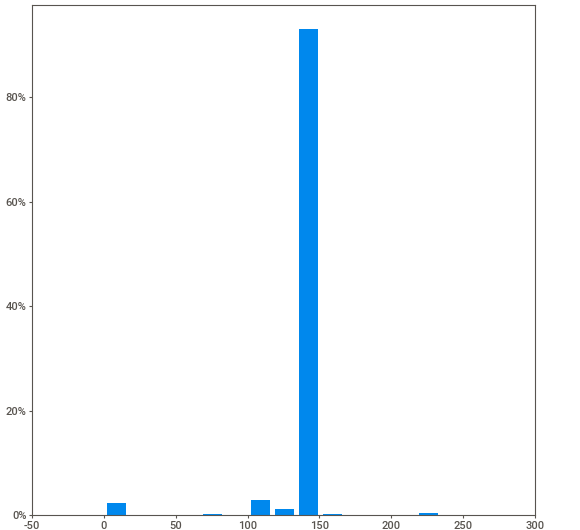
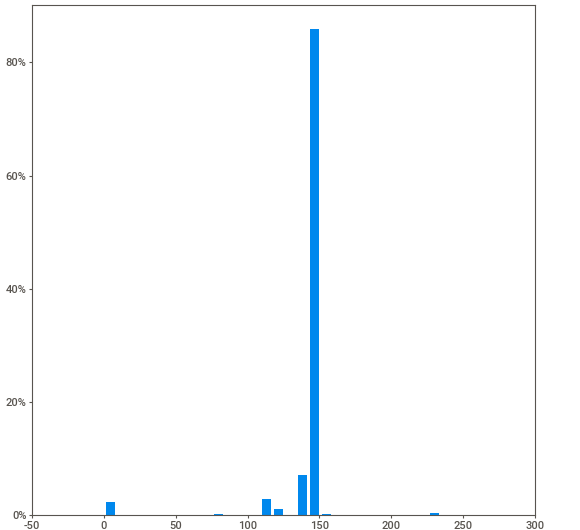
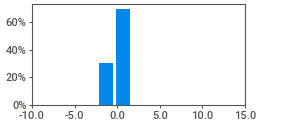
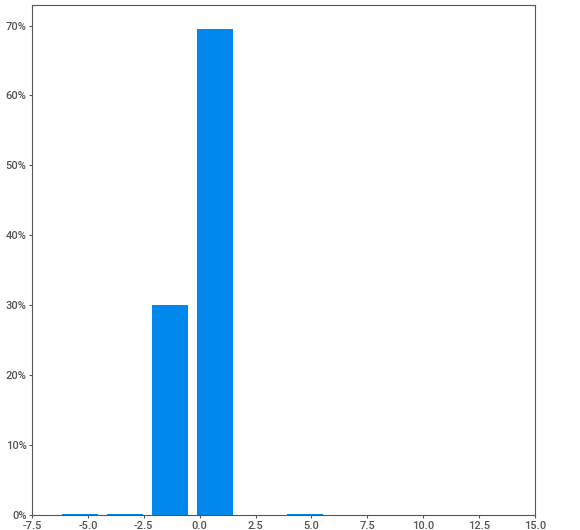
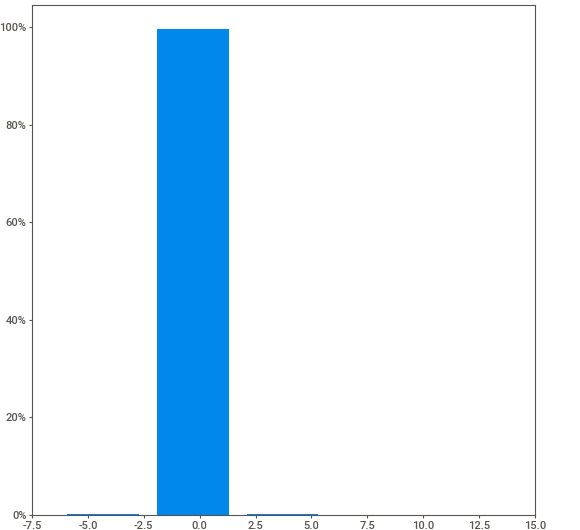
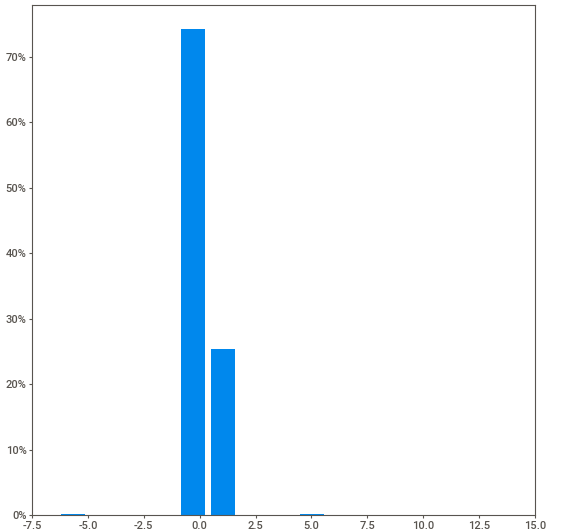
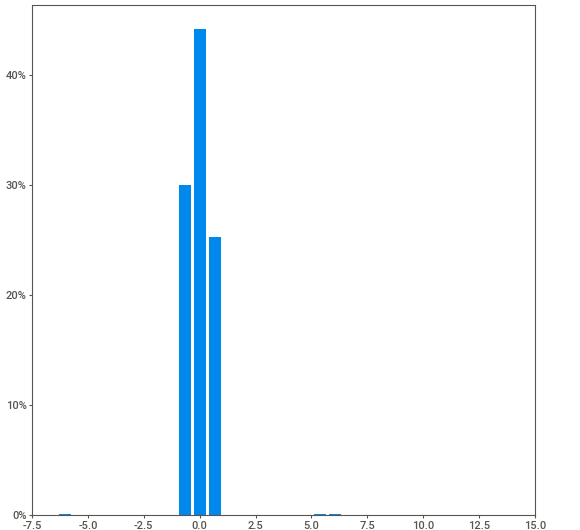
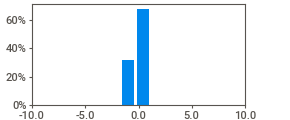
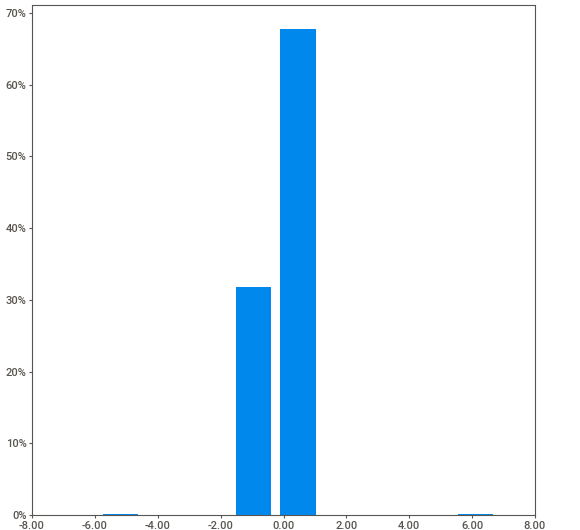
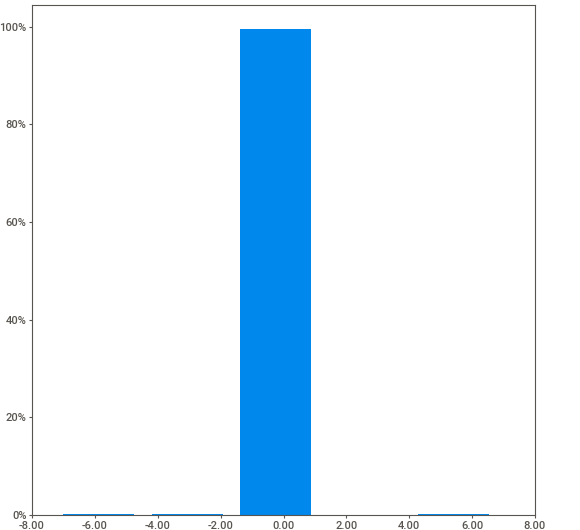
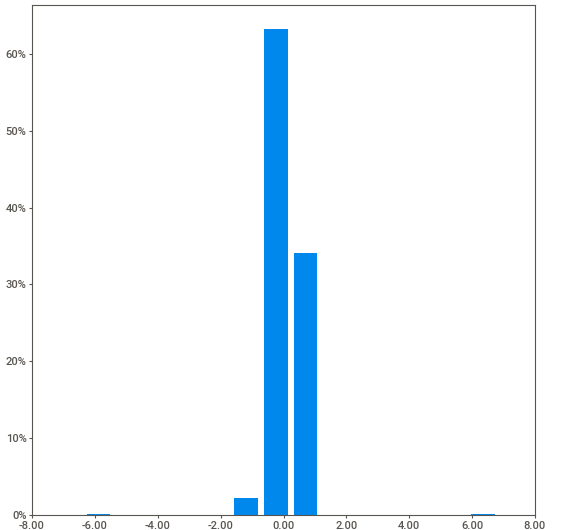
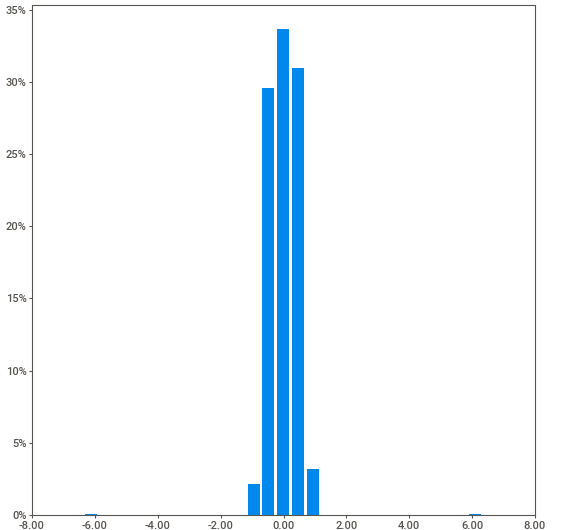
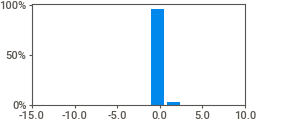
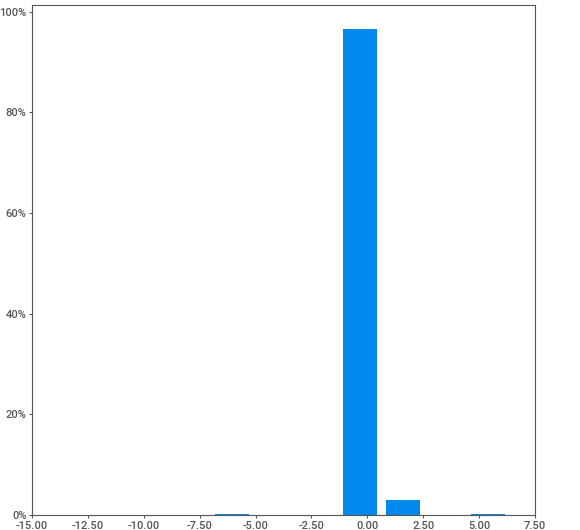
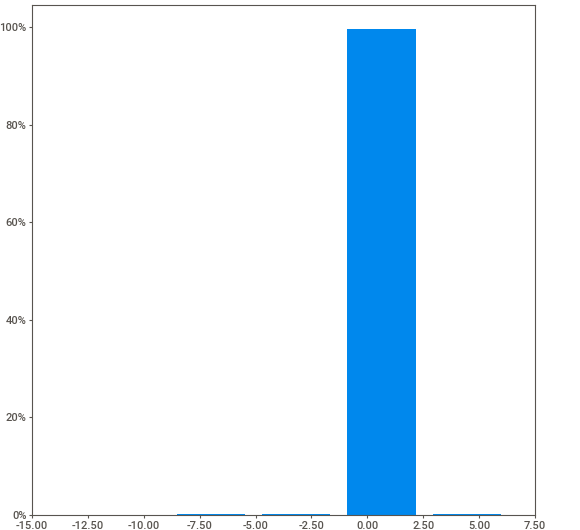
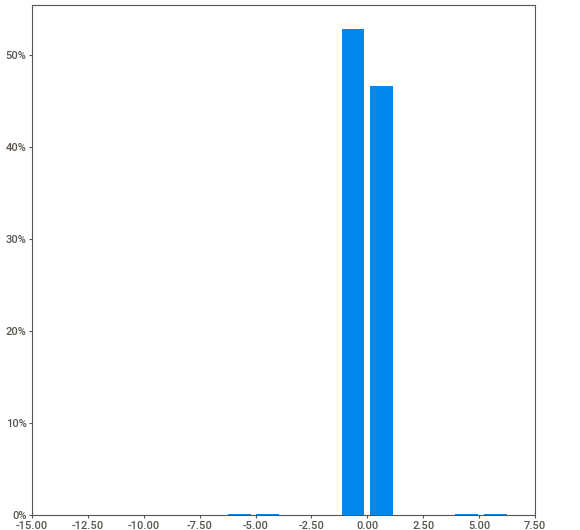
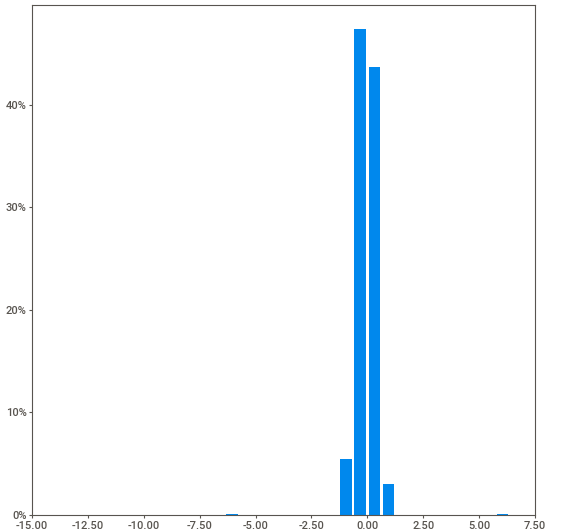
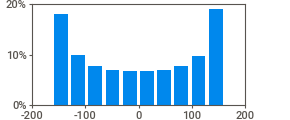
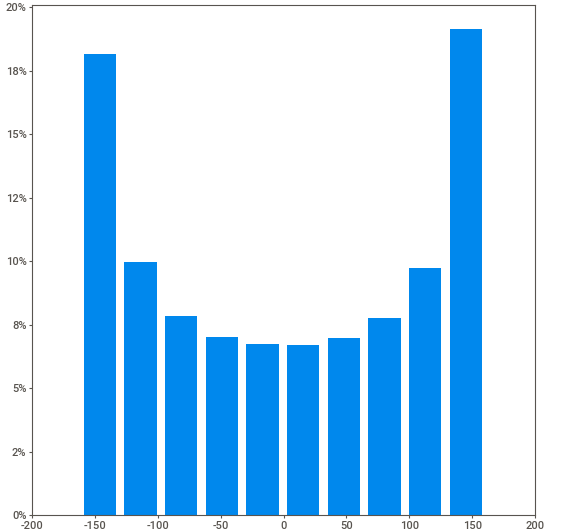
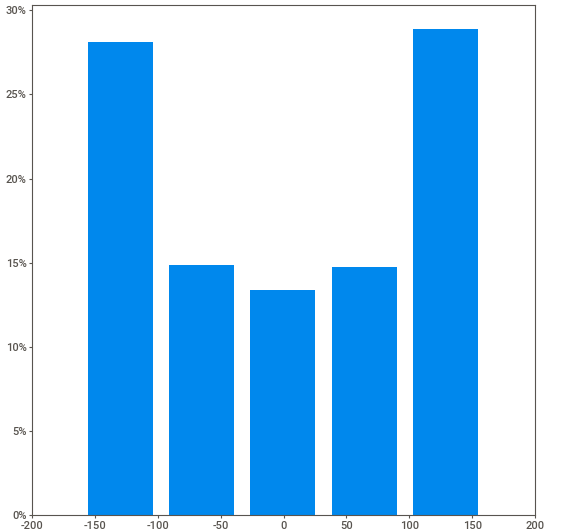
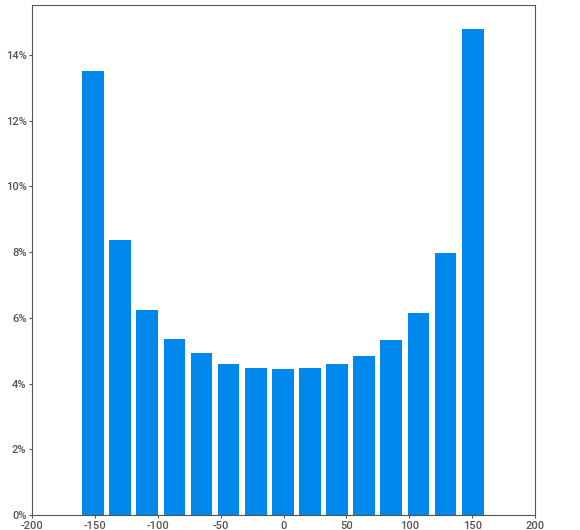
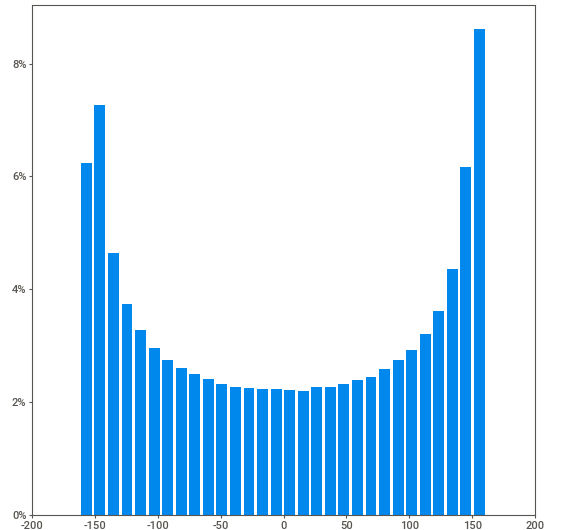
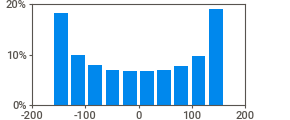
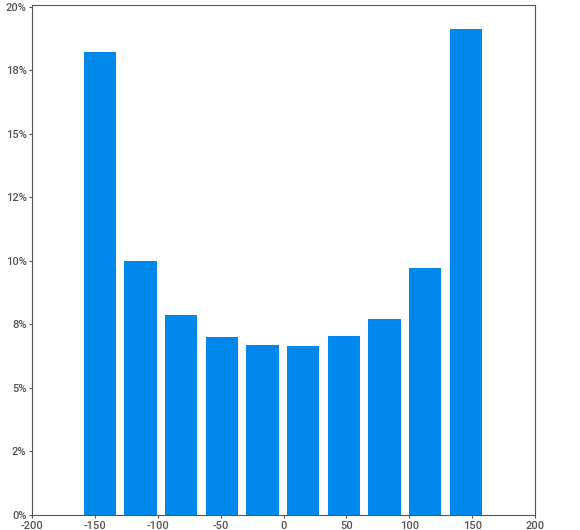
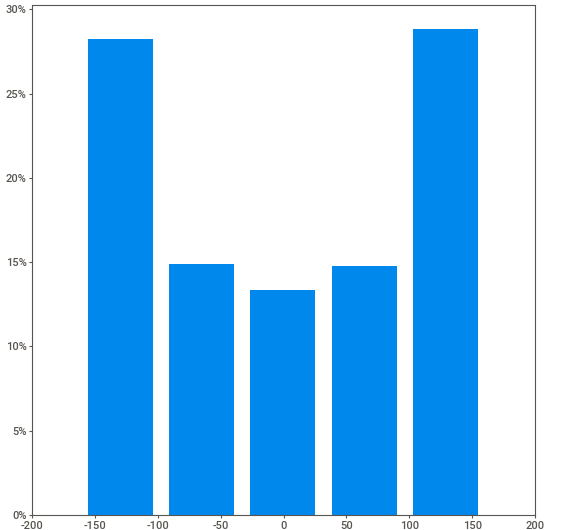
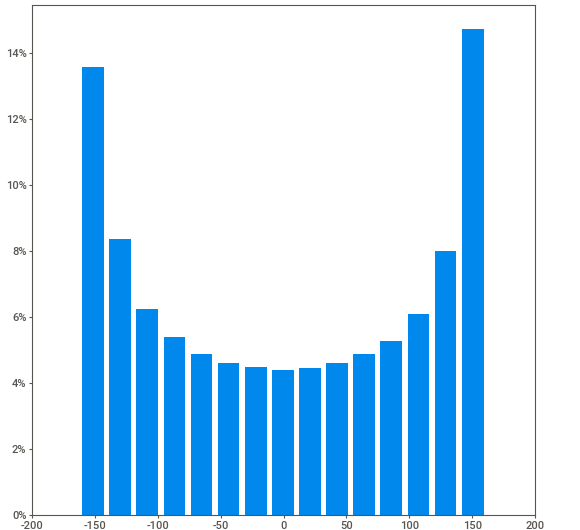
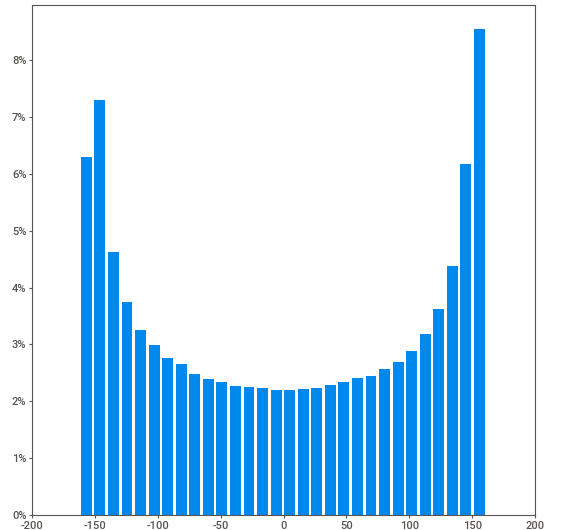
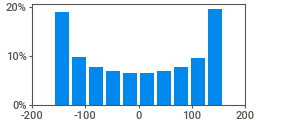
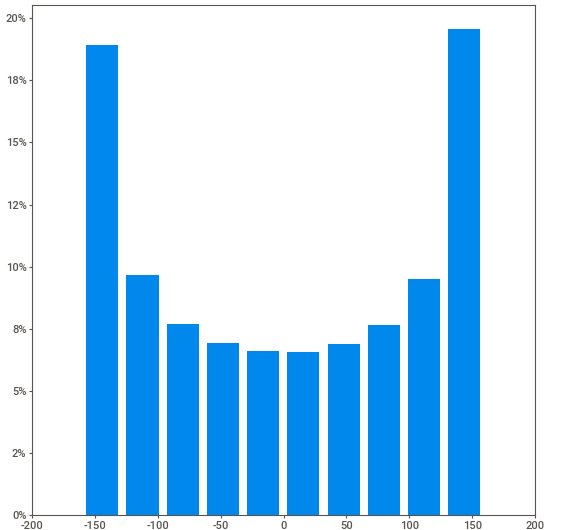
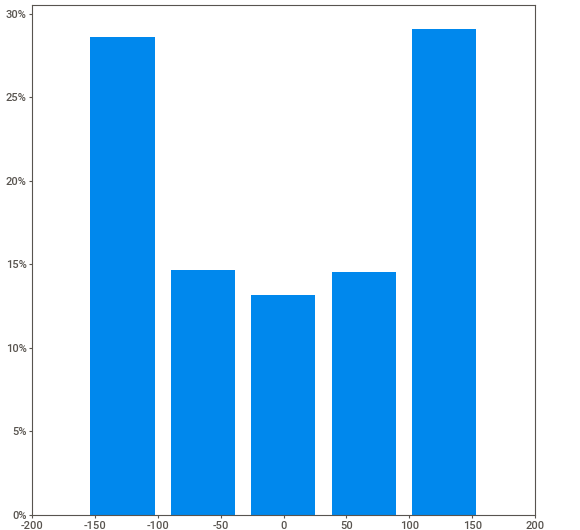
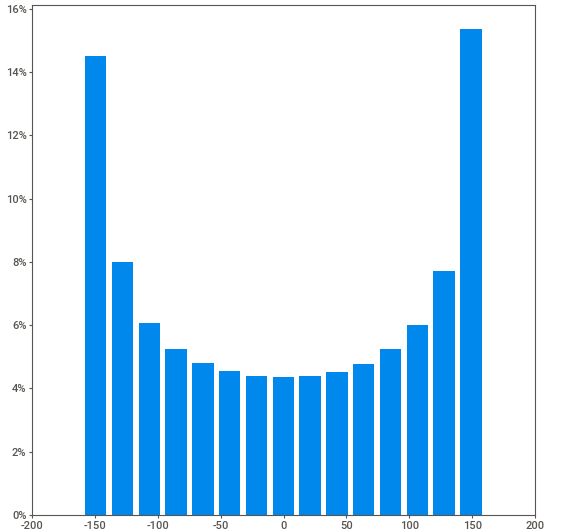
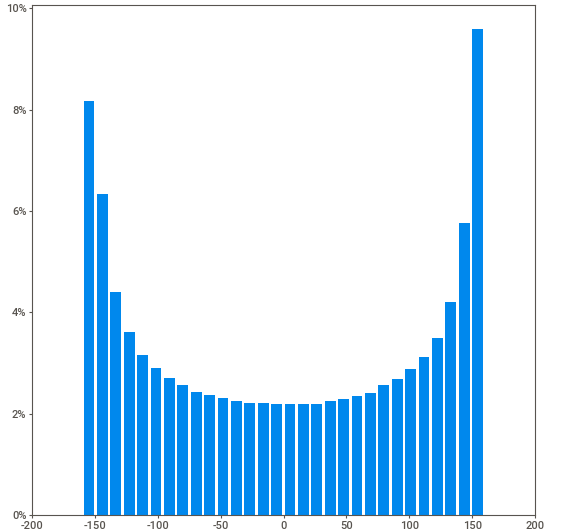
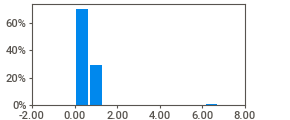
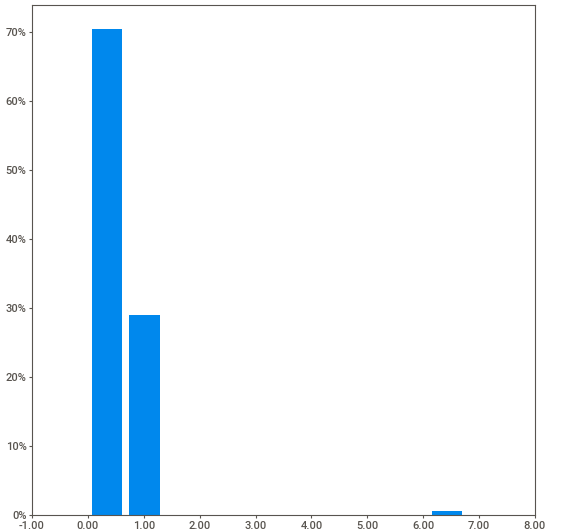
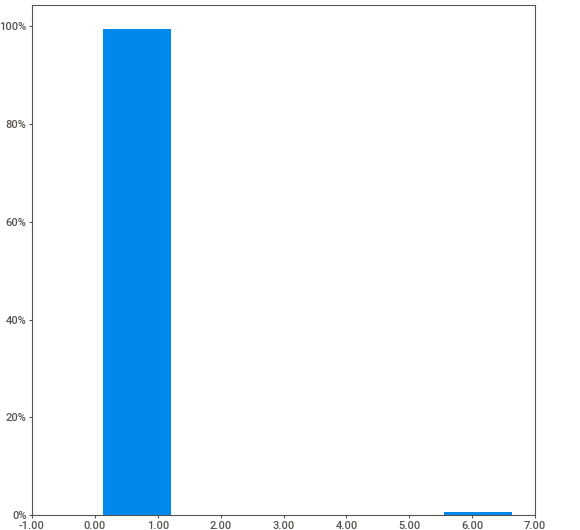
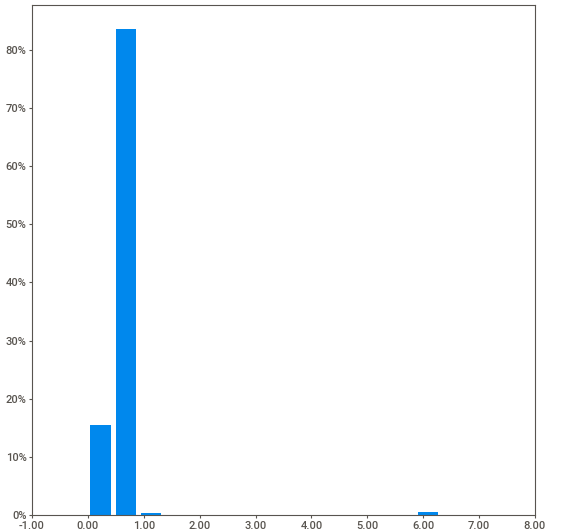
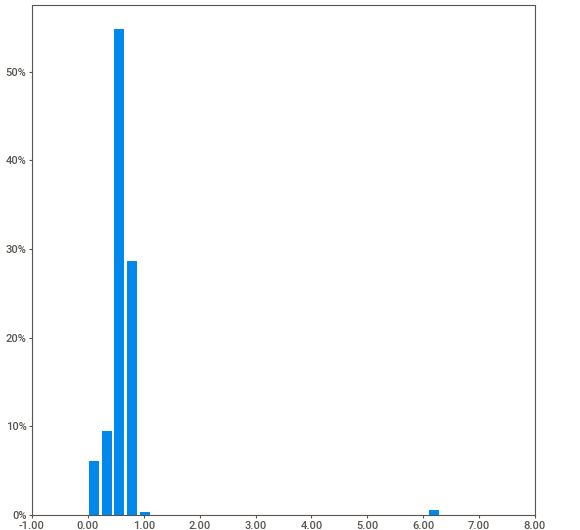
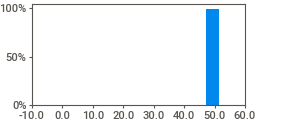
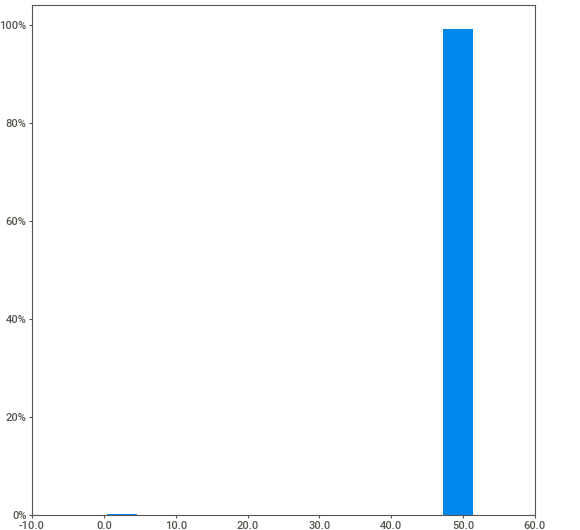
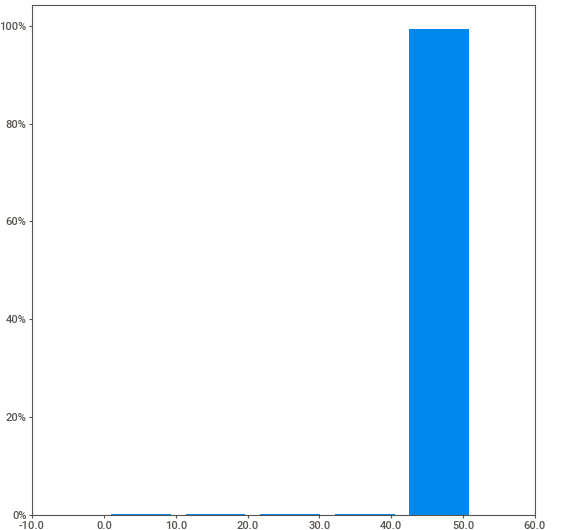
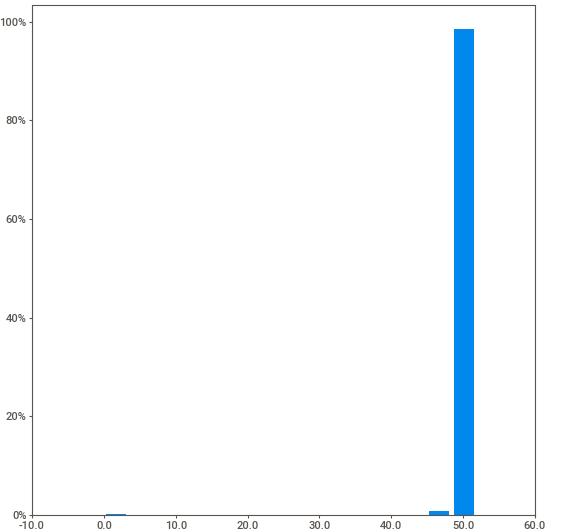
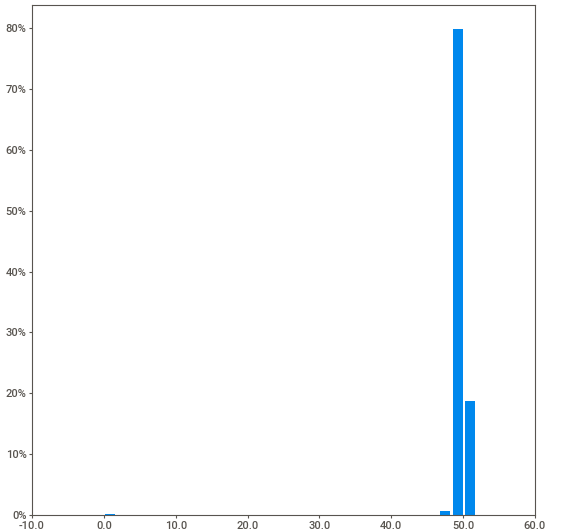
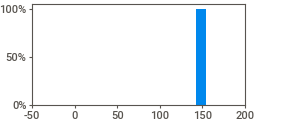
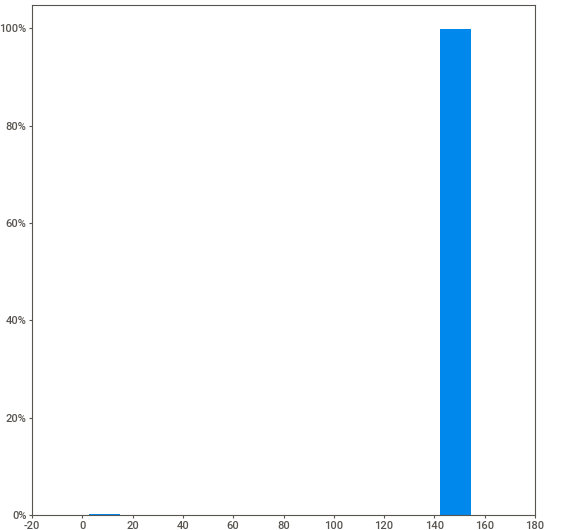
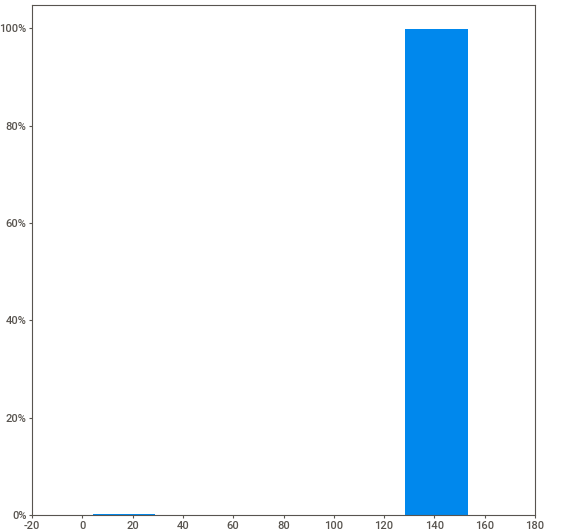
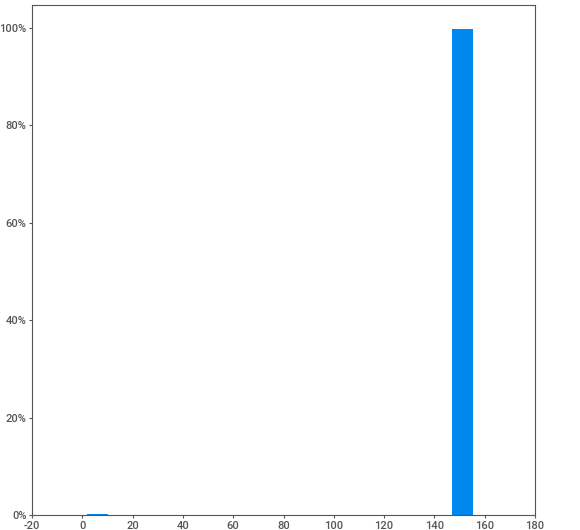
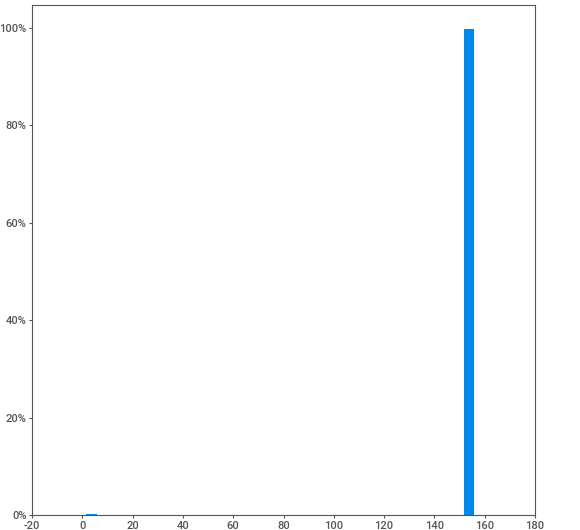
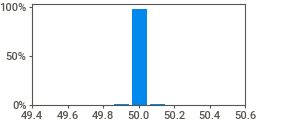
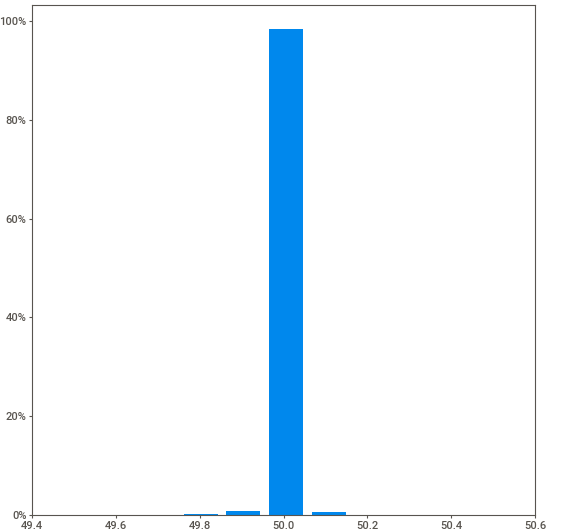
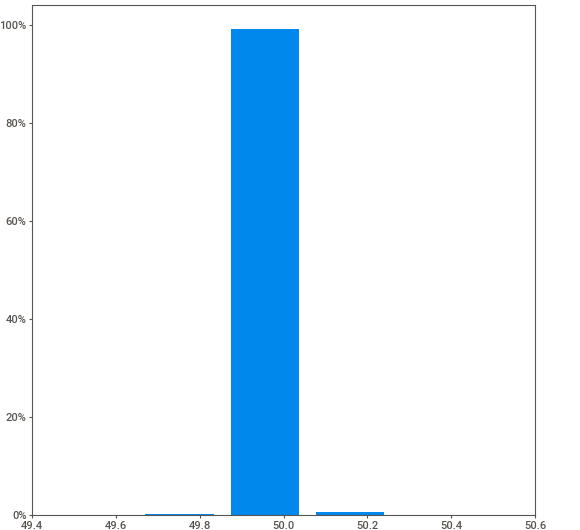
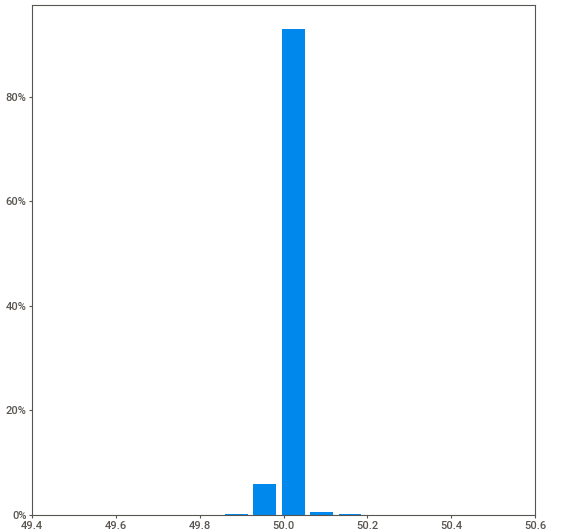
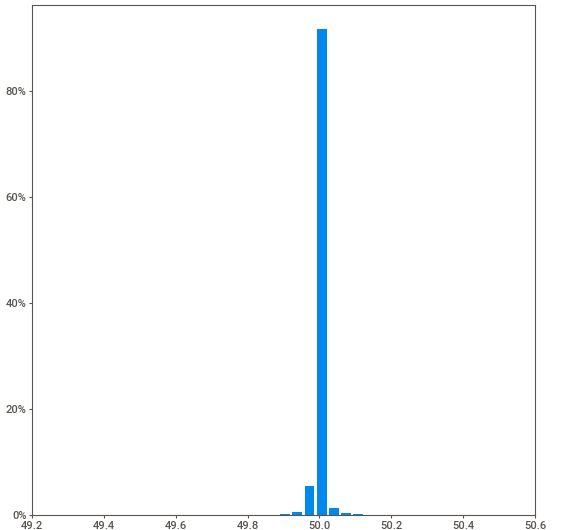
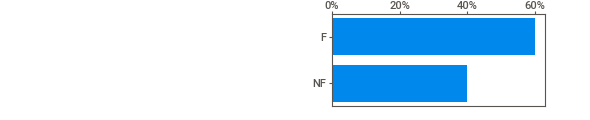
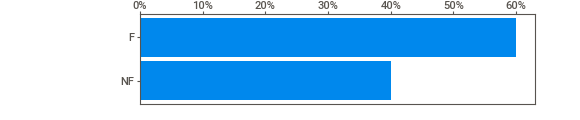
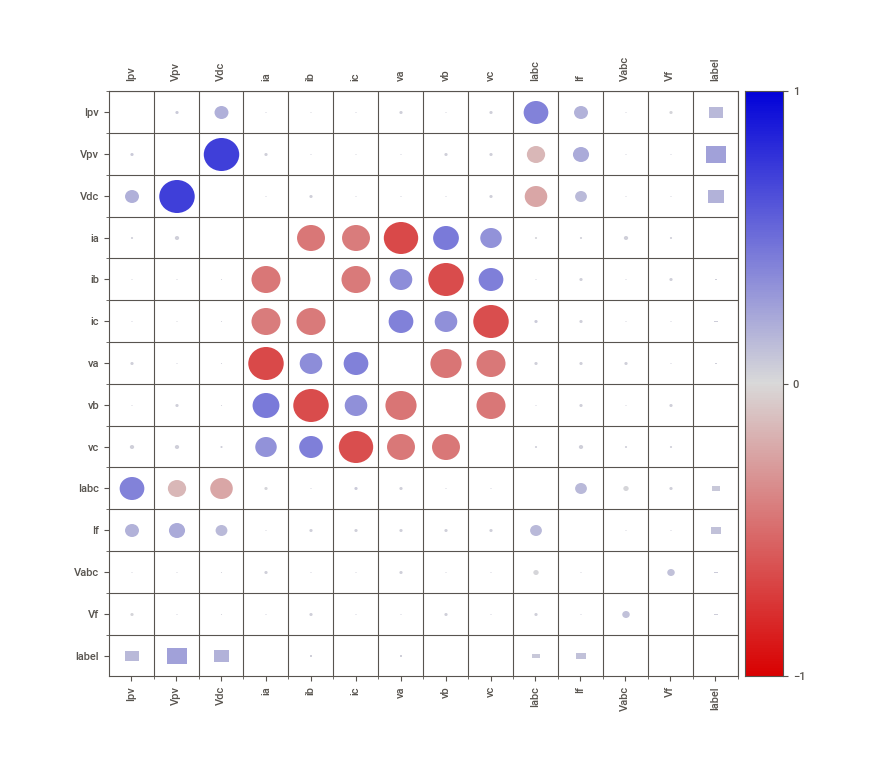
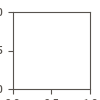

In [23]:
import sweetviz as sv

# Analyzing the dataset
report = sv.analyze(solar_data_final)

# Display the report
report.show_notebook()  # integrated report in notebook

# report.show_html('EDAreport.html') # html report generated in working directory


### PRE-PROCESSING

DATA IS CLEANED AND PREPROCESSING PIPELINES ARE CREATED

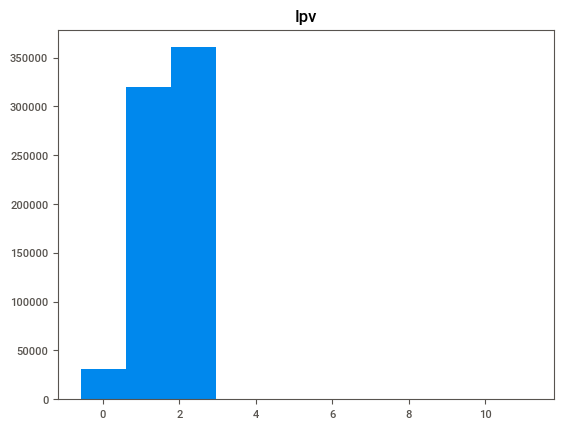

C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


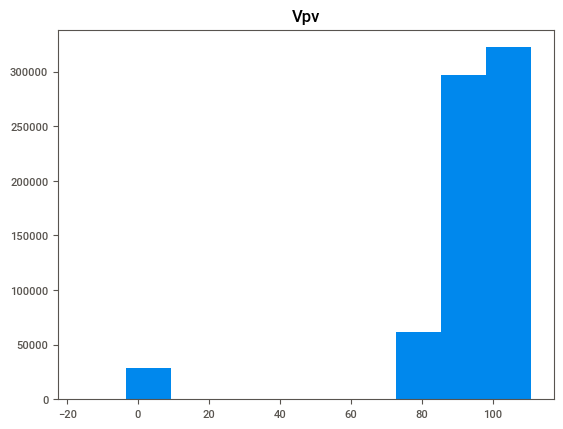

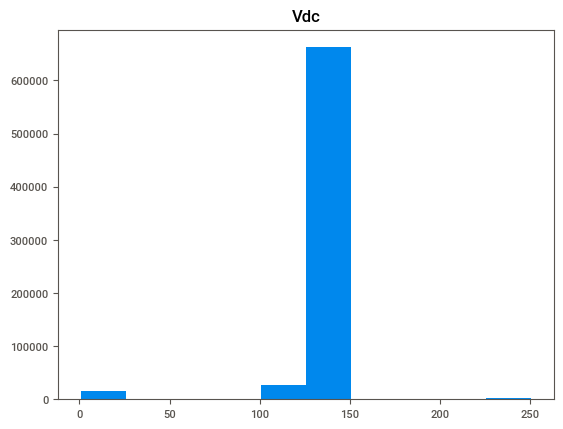

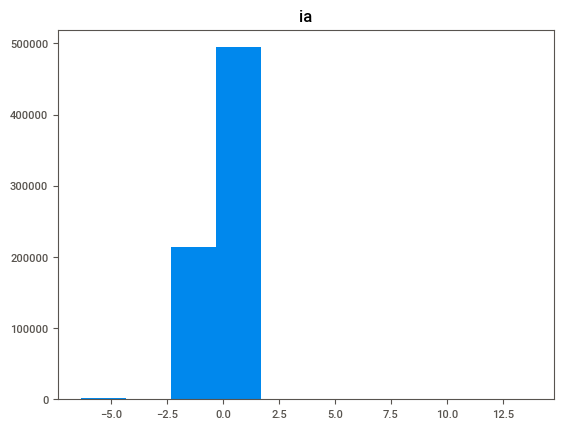

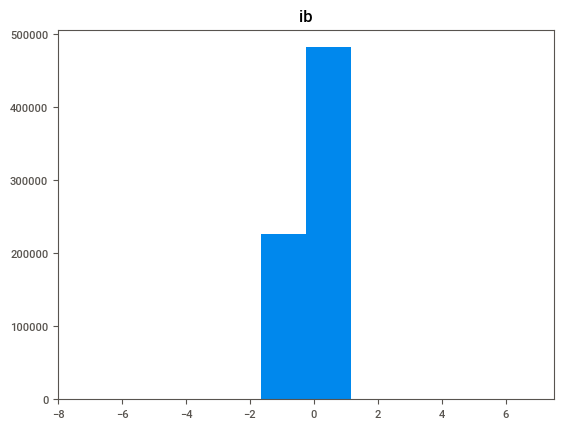

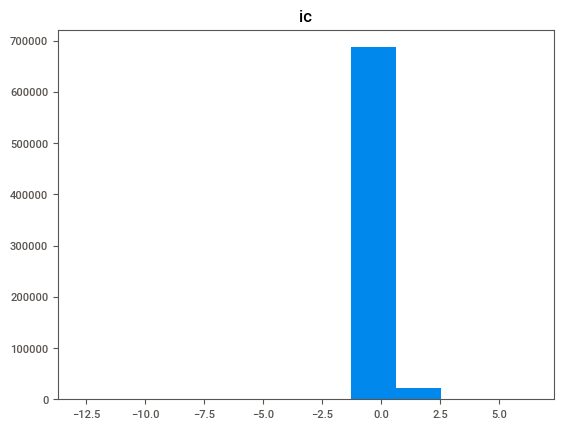

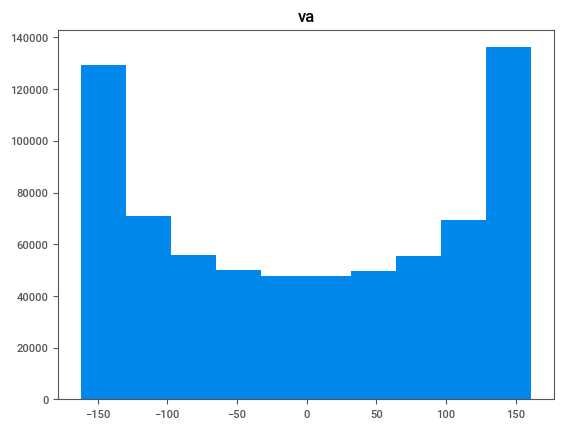

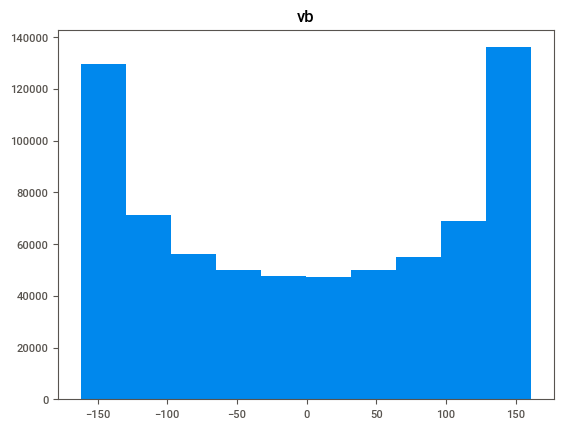

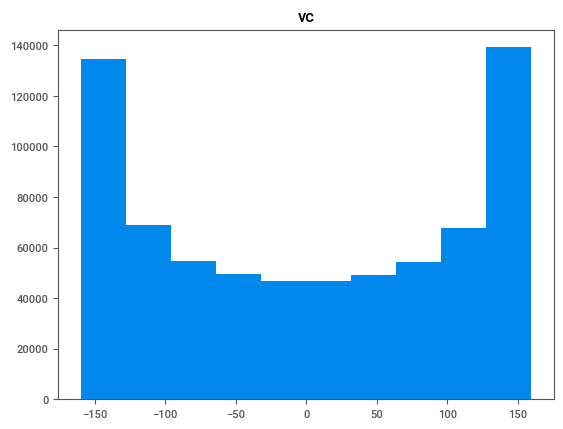

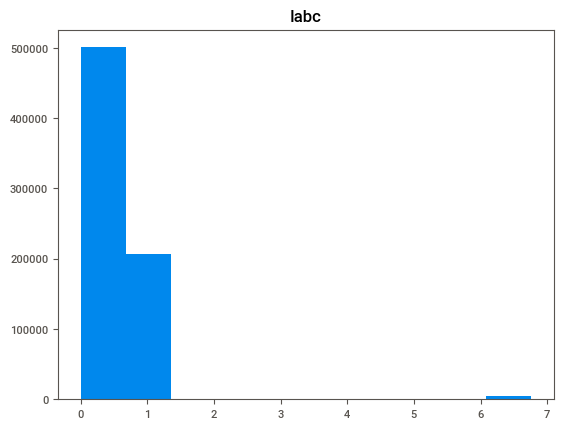

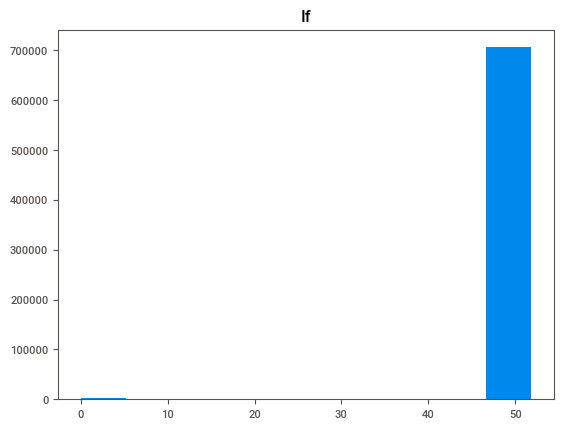

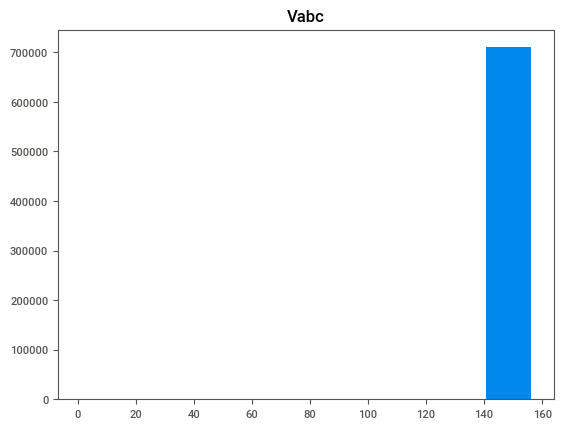

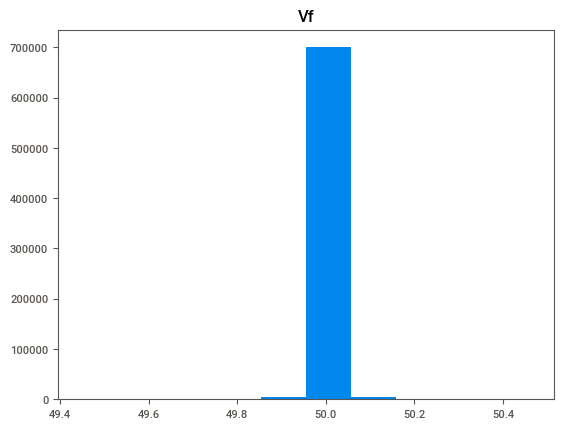

['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'va', 'vb', 'vc', 'Iabc', 'If', 'Vabc', 'Vf']


In [24]:
#Take out the features that require transformation
# initialize list to store non-normal features
non_normal_features = []

# iterate through features
for col in solar_data_final[Numerical_features]:
    # histogram plot
    plt.hist(solar_data_final[col])
    plt.title(col)
    plt.show()
    
    # Shapiro-Wilk test
    stat, p = shapiro(solar_data_final[col])
    if p < 0.05:
        non_normal_features.append(col)
        continue

print(non_normal_features)

## PREPROCESSING PIPELINES

APPLYING ROBUST SCALAR AS IT IS MORE SENSITIVE TO OUTLIERS.NOT APPLYING OUTLIER TREATMENT SEPARATELY.ONLY ONE NON NORMAL FEATURE SO APPLYING TRANSFORMATION ON ALL THE NUMERICAL FEATURES

In [25]:
# Creating pipeline for data preprocessing
# Defining the pipeline
pipeline = Pipeline([
    ("robust_scaler", RobustScaler()),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'))])


In [26]:
pipeline

Pipeline(steps=[('robust_scaler', RobustScaler()),
                ('yeo_johnson', PowerTransformer())])

In [27]:
# Fitting the pipeline to my df excluding label
pipeline.fit(solar_data_final[Numerical_features])

# Using the pipeline to transform the data
solar_data_final_transformed = pipeline.transform(solar_data_final[Numerical_features])

In [28]:
solar_data_final_transformed

array([[-0.645311  ,  0.9623397 ,  0.03279025, ..., -0.4983052 ,
        -0.89396029, -0.12129013],
       [ 1.18949462, -0.88859865,  0.2657254 , ...,  0.1968263 ,
        -0.72972182,  0.18840924],
       [ 0.07113014, -0.74968613,  0.03279025, ..., -0.16356011,
         0.21187331, -0.34295385],
       ...,
       [ 0.74869364, -0.52645691,  0.18391559, ..., -0.55905611,
         0.7668599 , -0.39063261],
       [ 0.71805004, -0.51551172,  0.2449292 , ..., -0.55905611,
         0.7668599 , -0.39063261],
       [ 0.86830398, -0.52645691,  0.2449292 , ..., -0.55905611,
         0.7668599 , -0.39063261]])

In [29]:
## FINAL TRANSFORMED DF EXCLUDING LABEL COLUMN
solar_data_final_df = pd.DataFrame(solar_data_final_transformed, columns=['Ipv','Vpv','Vdc','ia','ib','ic','va','vb','vc','Iabc','If','Vabc','Vf'])
solar_data_final_df

Ipv       Vpv       Vdc        ia        ib        ic        va  \
0      -0.645311  0.962340  0.032790 -0.533762  0.912356 -0.215727  1.032780   
1       1.189495 -0.888599  0.265725 -1.212553  0.675489  0.642876  1.402151   
2       0.071130 -0.749686  0.032790  0.007015 -0.802880  0.949438 -0.035662   
3       1.274519 -0.797362  0.286740  0.560661  0.787722 -1.220828 -0.669244   
4       1.620513 -0.726297  0.125124  0.447394 -1.092437  0.949438 -0.393965   
...          ...       ...       ...       ...       ...       ...       ...   
711818  0.791434 -0.535224  0.244929  1.164914 -1.155430 -0.061589 -1.219095   
711819  0.720401 -0.529044  0.244929  1.177505 -1.168030 -0.112950 -1.244620   
711820  0.748694 -0.526457  0.183916  1.190097 -1.130231 -0.164330 -1.262038   
711821  0.718050 -0.515512  0.244929  1.215279 -1.130231 -0.202876 -1.283618   
711822  0.868304 -0.526457  0.244929  1.227871 -1.079840 -0.215727 -1.295887   

              vb        vc      Iabc        If      Vabc        Vf  
0      -1.346560  0.295803 -0.171129 -0.498305 -0.893960 -0.121290  
1      -0.732177 -0.690652  0.554738  0.196826 -0.729722  0.188409  
2       1.228809 -1.221118 -0.062023 -0.163560  0.211873 -0.342954  
3      -0.738221  1.427637  0.755890 -0.285881  3.327897  0.264723  
4       1.354045 -1.004548  0.538686 -0.092118 -0.997693 -0.307785  
...          ...       ...       ...       ...       ...       ...  
711818  1.240643  0.018427  0.744069 -0.552968  0.754304 -0.420717  
711819  1.217632  0.063043  0.744069 -0.552968  0.754304 -0.420717  
711820  1.192100  0.106305  0.743909 -0.559056  0.766860 -0.390633  
711821  1.175334  0.149969  0.743909 -0.559056  0.766860 -0.390633  
711822  1.138185  0.194802  0.743909 -0.559056  0.766860 -0.390633  

[711823 rows x 13 columns]

### SPLITTING THE TRAIN AND TEST

In [30]:
# input variables and target variable separation
X = solar_data_final_df
y = solar_data_final['label']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# view the class counts in the training set
print("Class counts in training set:")
print(pd.Series(y_train).value_counts())

# view the class counts in the test set
print("Class counts in test set:")
print(pd.Series(y_test).value_counts())


Class counts in training set:
F     341734
NF    227724
Name: label, dtype: int64
Class counts in test set:
F     85360
NF    57005
Name: label, dtype: int64


### MODEL TRAINING AND EVALUATION

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
algorithms = {'Logistic Regression': LogisticRegression(solver='sag', max_iter=1000),
              'KNN': KNeighborsClassifier(weights='distance'),
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'SVM': SVC()}
# Iterate over the algorithms
for name, algorithm in algorithms.items():
    # Fit the algorithm to the training data
    algorithm.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = algorithm.predict(X_test)
    # Print the accuracy score on the test set
    print(f'{name} Test Accuracy: {accuracy_score(y_test, y_pred):.3f}')
    # Print the classification report on the test set
    print(f'{name} Test classification report:\n{classification_report(y_test, y_pred)}')


Logistic Regression Test Accuracy: 0.747
Logistic Regression Test classification report:
              precision    recall  f1-score   support

           F       0.81      0.76      0.78     85360
          NF       0.67      0.72      0.70     57005

    accuracy                           0.75    142365
   macro avg       0.74      0.74      0.74    142365
weighted avg       0.75      0.75      0.75    142365

KNN Test Accuracy: 0.949
KNN Test classification report:
              precision    recall  f1-score   support

           F       1.00      0.92      0.96     85360
          NF       0.89      0.99      0.94     57005

    accuracy                           0.95    142365
   macro avg       0.94      0.96      0.95    142365
weighted avg       0.95      0.95      0.95    142365

Decision Tree Test Accuracy: 0.977
Decision Tree Test classification report:
              precision    recall  f1-score   support

           F       0.98      0.98      0.98     85360
          NF  

-     Based on the results you've provided, it appears that the Random Forest method has the highest accuracy (98.7%) for detecting fault cases compared to Logistic Regression (74.7%), KNN (94.9%), Decision Tree (97.7%), SVM (96.3%).

 -     Based on the results you've provided, it appears that the Random Forest method has the highest accuracy (98.7%) for detecting fault cases compared to Logistic Regression (74.7%), KNN (94.9%), Decision Tree (97.7%), SVM (96.3%).

-   Based on these results, we can conclude that the Random Forest method is the most effective model for detecting fault cases in this particular dataset. The high accuracy and precision of the Random Forest method make it a reliable model for classifying fault and non-fault cases.

### MODEL TUNING

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer, recall_score

# Define the parameter grid for the random search
param_dist = {'n_estimators': sp_randint(50, 200),
              'max_depth': [3, None],
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, 11),
              'min_samples_leaf': sp_randint(1, 11),
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

# Create a random forest classifier
rf = RandomForestClassifier()

# Define a custom scorer for recall
recall_scorer = make_scorer(recall_score, greater_is_better=True)

# Create the randomized search object
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, scoring=recall_scorer)

# Fit the randomized search object to the data
random_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = random_search.best_params_
print("Best Parameters: ",best_params)


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 12, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 146}
Best Score:  nan


### MODEL PREDICTION

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model with the best parameters
rf_model = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=None, max_features=12, min_samples_leaf=5, min_samples_split=10, n_estimators=146)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Use the model to predict on the test data
y_pred = rf_model.predict(X_test)


In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           F       0.99      0.98      0.99     85360
          NF       0.98      0.98      0.98     57005

    accuracy                           0.98    142365
   macro avg       0.98      0.98      0.98    142365
weighted avg       0.98      0.98      0.98    142365



### MODEL EVALUATION

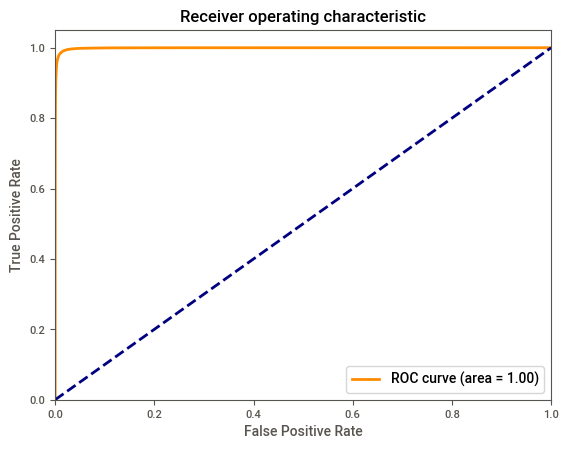

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = algorithms['Random Forest'].predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='NF')
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


### PREDICTION ON NEW DATA

In [49]:
solar_data_final_transformed[0].reshape(1,-1)

array([[-0.645311  ,  0.9623397 ,  0.03279025, -0.53376165,  0.91235592,
        -0.21572679,  1.03277967, -1.34655955,  0.29580257, -0.17112937,
        -0.4983052 , -0.89396029, -0.12129013]])

In [50]:
algorithms['Random Forest'].predict(solar_data_final_transformed[0].reshape(1,-1))

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['F'], dtype=object)

### PICKLING THE MODEL FILE

In [51]:

# Define the model with the preprocessing pipelines
model = Pipeline([("robust_scaler", RobustScaler()),
('yeo_johnson', PowerTransformer(method='yeo-johnson')),
('simple_imputer', SimpleImputer()),
('random_forest', RandomForestClassifier())])


In [52]:
import pickle 
pickle.dump(model,open('model.pkl','wb'))

In [53]:
pickled_model=pickle.load(open('model.pkl','rb'))